# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/ex7/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
pd.DataFrame(ext_data['train']['features'])

,0,1,2,3,4,5,6,7,8,9,...,3766,3767,3768,3769,3770,3771,3772,3773,3774,3775
0,0.243716,0.338328,0.272088,0.226127,0.029367,0.339973,0.209255,0.105823,0.137297,0.145012,...,0.022174,0.006773,0.069666,0.301964,0.180498,0.033291,0.098398,0.024299,0.016897,0.123153
1,0.237665,0.327515,0.263212,0.232293,0.027842,0.367579,0.210006,0.094775,0.134482,0.143913,...,0.027657,0.028354,0.165744,0.330388,0.136494,0.035396,0.146613,0.123391,0.007483,0.144597
2,0.225514,0.379070,0.276066,0.196089,0.027455,0.265828,0.224954,0.132161,0.143215,0.143278,...,0.040949,0.034133,0.122343,0.213779,0.166338,0.049096,0.042672,0.044685,0.002102,0.145841
3,0.241087,0.328841,0.287649,0.230211,0.029166,0.339409,0.215851,0.104063,0.135149,0.140004,...,0.047530,0.000834,0.029579,0.157189,0.159237,0.092072,0.176285,0.072260,0.025339,0.222447
4,0.247998,0.328309,0.278905,0.237095,0.027144,0.362545,0.209568,0.100579,0.133083,0.137760,...,0.022089,0.001686,0.082939,0.303310,0.165293,0.078591,0.169059,0.093608,0.015137,0.118250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013,0.242294,0.320149,0.291148,0.246376,0.024519,0.336719,0.213888,0.098774,0.152700,0.135828,...,0.028749,0.020032,0.089271,0.324535,0.164114,0.011856,0.131130,0.048871,0.016199,0.125525
6014,0.239820,0.328761,0.283221,0.232255,0.026091,0.329097,0.217799,0.107723,0.151887,0.142054,...,0.065597,0.009168,0.159468,0.321171,0.235521,0.020378,0.059581,0.037248,0.034675,0.046954
6015,0.233884,0.312639,0.287863,0.243157,0.024677,0.309460,0.243808,0.103488,0.180332,0.135159,...,0.159631,0.007203,0.071548,0.284185,0.112961,0.240836,0.032650,0.014332,0.023457,0.157205
6016,0.232720,0.344319,0.275893,0.233720,0.027888,0.292808,0.227276,0.124664,0.170116,0.145821,...,0.098789,0.002348,0.054095,0.253814,0.089476,0.159530,0.034791,0.019259,0.031108,0.169736


## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [11]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

In [12]:
#for machine_type in machine_types:
#    run(machine_type)

2021-05-26 23:07:09,122 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-05-26 23:07:09,124 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-26 23:07:09,178 - 00_train.py - INFO - TRAINING
2021-05-26 23:07:13,511 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.58it/s]
2021-05-26 23:07:14,550 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.73it/s]
2021-05-26 23:07:14,747 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 361.1151123046875, KLd: 9.394340515136719, center_loss: 351.5776062011719


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


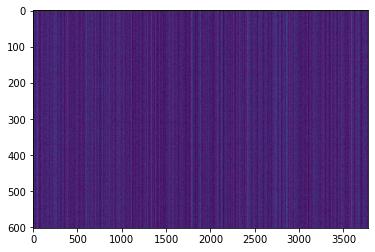

,AUC,pAUC
Source_0,0.458700,0.485263
Source_1,0.581400,0.530000
Source_2,0.735027,0.627076
Target_0,0.508700,0.530526
Target_1,0.507347,0.494844
Target_2,0.606594,0.503025
mean,0.566295,0.528456
h_mean,0.553202,0.524661


2021-05-26 23:07:16,385 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:62295.830729, val_AUC_hmean:0.553202, val_pAUC_hmean:0.524661, best_flag:True
2021-05-26 23:07:16,386 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.76it/s]
2021-05-26 23:07:17,328 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.33it/s]
2021-05-26 23:07:17,556 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 361.4399108886719, KLd: 19.878265380859375, center_loss: 341.35491943359375


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


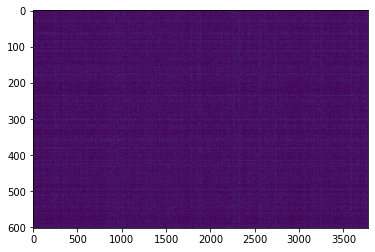

,AUC,pAUC
Source_0,0.490900,0.486316
Source_1,0.650300,0.563158
Source_2,0.760250,0.699315
Target_0,0.495800,0.504737
Target_1,0.557143,0.511923
Target_2,0.585448,0.529230
mean,0.589973,0.549113
h_mean,0.576364,0.541216


2021-05-26 23:07:19,280 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:46404.037109, val_AUC_hmean:0.576364, val_pAUC_hmean:0.541216, best_flag:True
2021-05-26 23:07:19,282 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.83it/s]
2021-05-26 23:07:20,153 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.23it/s]
2021-05-26 23:07:20,356 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 333.97454833984375, KLd: 20.852767944335938, center_loss: 312.9580383300781


100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


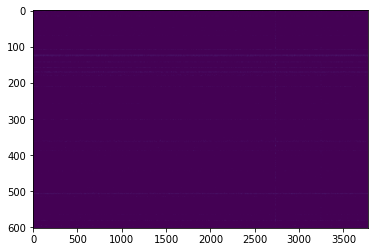

,AUC,pAUC
Source_0,0.525900,0.493684
Source_1,0.671100,0.606842
Source_2,0.788681,0.749977
Target_0,0.496500,0.502105
Target_1,0.602245,0.509452
Target_2,0.603422,0.573646
mean,0.614641,0.572618
h_mean,0.600522,0.560508


2021-05-26 23:07:22,056 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:39364.864258, val_AUC_hmean:0.600522, val_pAUC_hmean:0.560508, best_flag:True
2021-05-26 23:07:22,058 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.13it/s]
2021-05-26 23:07:22,975 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.68it/s]
2021-05-26 23:07:23,201 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 290.73388671875, KLd: 14.954833984375, center_loss: 275.58294677734375


100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


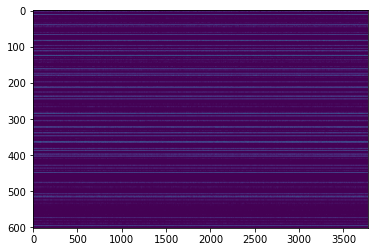

,AUC,pAUC
Source_0,0.588000,0.503684
Source_1,0.777200,0.614211
Source_2,0.801426,0.773431
Target_0,0.486200,0.500000
Target_1,0.632857,0.515252
Target_2,0.623991,0.584876
mean,0.651612,0.581909
h_mean,0.633271,0.568345


2021-05-26 23:07:24,728 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:35673.072917, val_AUC_hmean:0.633271, val_pAUC_hmean:0.568345, best_flag:True
2021-05-26 23:07:24,730 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.41it/s]
2021-05-26 23:07:25,293 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-26 23:07:25,495 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 253.45497131347656, KLd: 9.645766258239746, center_loss: 243.57659912109375


100%|██████████| 2/2 [00:00<00:00, 11.77it/s]


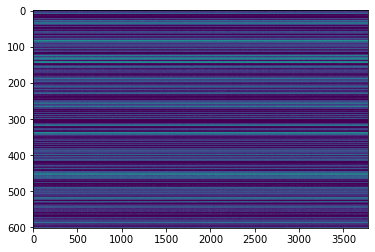

,AUC,pAUC
Source_0,0.649900,0.512105
Source_1,0.880000,0.689474
Source_2,0.819162,0.781405
Target_0,0.469800,0.499474
Target_1,0.673367,0.540709
Target_2,0.639369,0.546834
mean,0.688600,0.595000
h_mean,0.661266,0.578978


2021-05-26 23:07:27,160 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:33239.451009, val_AUC_hmean:0.661266, val_pAUC_hmean:0.578978, best_flag:True
2021-05-26 23:07:27,161 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.56it/s]
2021-05-26 23:07:27,987 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.68it/s]
2021-05-26 23:07:28,216 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 244.7121124267578, KLd: 7.153252601623535, center_loss: 237.3063201904297


100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


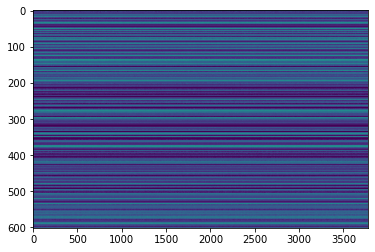

,AUC,pAUC
Source_0,0.719300,0.534737
Source_1,0.917200,0.726316
Source_2,0.819964,0.784689
Target_0,0.441500,0.495789
Target_1,0.649694,0.553706
Target_2,0.590254,0.502519
mean,0.689652,0.599626
h_mean,0.652283,0.580594


2021-05-26 23:07:29,909 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:32039.405111, val_AUC_hmean:0.652283, val_pAUC_hmean:0.580594, best_flag:True
2021-05-26 23:07:29,910 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.38it/s]
2021-05-26 23:07:30,747 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.93it/s]
2021-05-26 23:07:30,995 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 243.23577880859375, KLd: 6.277176856994629, center_loss: 236.7115478515625


100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


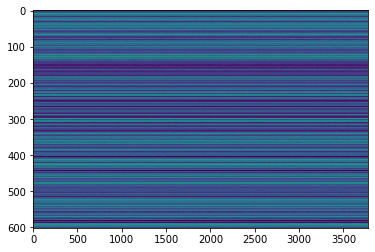

,AUC,pAUC
Source_0,0.781600,0.576316
Source_1,0.899800,0.729474
Source_2,0.821123,0.794540
Target_0,0.443600,0.490526
Target_1,0.627041,0.542213
Target_2,0.598712,0.498472
mean,0.695313,0.605257
h_mean,0.657321,0.585157


2021-05-26 23:07:32,601 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:31173.996908, val_AUC_hmean:0.657321, val_pAUC_hmean:0.585157, best_flag:True
2021-05-26 23:07:32,602 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.18it/s]
2021-05-26 23:07:33,394 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-26 23:07:33,610 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 236.9633331298828, KLd: 5.915074348449707, center_loss: 230.8182373046875


100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-26 23:07:33,825 - pytorch_modeler.py - INFO - epoch:8/300, train_losses:30295.612142, val_AUC_hmean:0.648792, val_pAUC_hmean:0.582201, best_flag:False
2021-05-26 23:07:33,827 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.56it/s]
2021-05-26 23:07:34,653 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-26 23:07:34,870 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 235.55850219726562, KLd: 5.00321626663208, center_loss: 230.32449340820312


100%|██████████| 2/2 [00:00<00:00,  9.48it/s]
2021-05-26 23:07:35,132 - pytorch_modeler.py - INFO - epoch:9/300, train_losses:29822.361654, val_AUC_hmean:0.656449, val_pAUC_hmean:0.583508, best_flag:False
2021-05-26 23:07:35,134 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.67it/s]
2021-05-26 23:07:36,014 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.32it/s]
2021-05-26 23:07:36,213 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 231.0070343017578, KLd: 4.250724792480469, center_loss: 226.51910400390625


100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


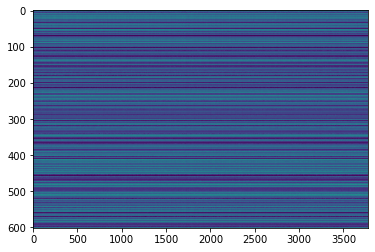

,AUC,pAUC
Source_0,0.785800,0.586842
Source_1,0.906700,0.726316
Source_2,0.835472,0.803922
Target_0,0.459500,0.482105
Target_1,0.638367,0.532868
Target_2,0.609285,0.508691
mean,0.705854,0.606791
h_mean,0.669908,0.585854


2021-05-26 23:07:37,672 - pytorch_modeler.py - INFO - epoch:10/300, train_losses:29372.665365, val_AUC_hmean:0.669908, val_pAUC_hmean:0.585854, best_flag:True
2021-05-26 23:07:37,673 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.20it/s]
2021-05-26 23:07:38,520 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-26 23:07:38,728 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 232.48184204101562, KLd: 4.307520389556885, center_loss: 227.89804077148438


100%|██████████| 2/2 [00:00<00:00, 10.34it/s]
2021-05-26 23:07:38,954 - pytorch_modeler.py - INFO - epoch:11/300, train_losses:28856.391764, val_AUC_hmean:0.654010, val_pAUC_hmean:0.581315, best_flag:False
2021-05-26 23:07:38,956 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.00it/s]
2021-05-26 23:07:39,759 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-26 23:07:39,979 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 232.8193359375, KLd: 4.280399322509766, center_loss: 228.20867919921875


100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-26 23:07:40,192 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:28537.128906, val_AUC_hmean:0.663193, val_pAUC_hmean:0.577875, best_flag:False
2021-05-26 23:07:40,194 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.98it/s]
2021-05-26 23:07:40,997 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-26 23:07:41,206 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 227.05487060546875, KLd: 3.516132354736328, center_loss: 223.10015869140625


100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


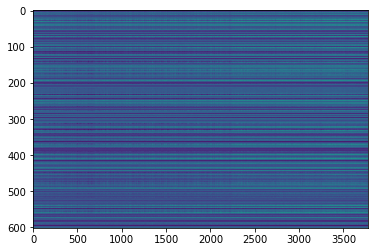

,AUC,pAUC
Source_0,0.793800,0.602105
Source_1,0.905100,0.743158
Source_2,0.828431,0.808143
Target_0,0.469800,0.481053
Target_1,0.634592,0.522449
Target_2,0.617839,0.502115
mean,0.708260,0.609837
h_mean,0.674564,0.586610


2021-05-26 23:07:42,740 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:28348.853841, val_AUC_hmean:0.674564, val_pAUC_hmean:0.586610, best_flag:True
2021-05-26 23:07:42,741 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.12it/s]
2021-05-26 23:07:43,536 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.58it/s]
2021-05-26 23:07:43,751 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 229.91639709472656, KLd: 3.506248950958252, center_loss: 225.90103149414062


100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


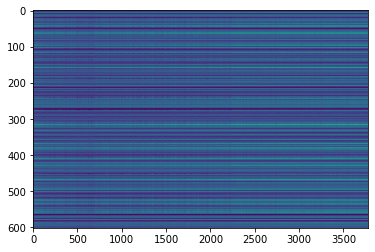

,AUC,pAUC
Source_0,0.794700,0.596842
Source_1,0.925700,0.791579
Source_2,0.822549,0.803922
Target_0,0.467300,0.481579
Target_1,0.632347,0.542105
Target_2,0.624664,0.525284
mean,0.711210,0.623552
h_mean,0.675938,0.599545


2021-05-26 23:07:45,341 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:27956.134277, val_AUC_hmean:0.675938, val_pAUC_hmean:0.599545, best_flag:True
2021-05-26 23:07:45,342 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.16it/s]
2021-05-26 23:07:46,136 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
2021-05-26 23:07:46,360 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 227.1713409423828, KLd: 3.1787240505218506, center_loss: 223.5341796875


100%|██████████| 2/2 [00:00<00:00, 10.61it/s]
2021-05-26 23:07:46,582 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:27993.806478, val_AUC_hmean:0.680158, val_pAUC_hmean:0.592326, best_flag:False
2021-05-26 23:07:46,583 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.94it/s]
2021-05-26 23:07:47,446 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-26 23:07:47,653 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 222.93414306640625, KLd: 2.939997911453247, center_loss: 219.66213989257812


100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-26 23:07:47,864 - pytorch_modeler.py - INFO - epoch:16/300, train_losses:27688.375163, val_AUC_hmean:0.683005, val_pAUC_hmean:0.589089, best_flag:False
2021-05-26 23:07:47,866 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.27it/s]
2021-05-26 23:07:48,709 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.23it/s]
2021-05-26 23:07:48,981 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 223.9945831298828, KLd: 2.9660913944244385, center_loss: 220.74465942382812


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]
2021-05-26 23:07:49,256 - pytorch_modeler.py - INFO - epoch:17/300, train_losses:27436.176107, val_AUC_hmean:0.679995, val_pAUC_hmean:0.593018, best_flag:False
2021-05-26 23:07:49,258 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.29it/s]
2021-05-26 23:07:50,104 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.79it/s]
2021-05-26 23:07:50,323 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 218.60276794433594, KLd: 2.687746047973633, center_loss: 215.70494079589844


100%|██████████| 2/2 [00:00<00:00,  9.20it/s]
2021-05-26 23:07:50,567 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:27304.292969, val_AUC_hmean:0.685512, val_pAUC_hmean:0.594978, best_flag:False
2021-05-26 23:07:50,568 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.28it/s]
2021-05-26 23:07:51,412 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.14it/s]
2021-05-26 23:07:51,684 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 220.90911865234375, KLd: 2.905644416809082, center_loss: 217.81617736816406


100%|██████████| 2/2 [00:00<00:00,  9.61it/s]
2021-05-26 23:07:51,920 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:27150.098307, val_AUC_hmean:0.691809, val_pAUC_hmean:0.597971, best_flag:False
2021-05-26 23:07:51,921 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.99it/s]
2021-05-26 23:07:52,781 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.28it/s]
2021-05-26 23:07:53,019 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 222.96090698242188, KLd: 2.892516851425171, center_loss: 219.9128875732422


100%|██████████| 2/2 [00:00<00:00,  9.65it/s]
2021-05-26 23:07:53,261 - pytorch_modeler.py - INFO - epoch:20/300, train_losses:26977.474935, val_AUC_hmean:0.672789, val_pAUC_hmean:0.594956, best_flag:False
2021-05-26 23:07:53,263 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.73it/s]
2021-05-26 23:07:54,028 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.05it/s]
2021-05-26 23:07:54,236 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 219.70809936523438, KLd: 2.4841036796569824, center_loss: 217.05645751953125


100%|██████████| 2/2 [00:00<00:00,  9.90it/s]
2021-05-26 23:07:54,468 - pytorch_modeler.py - INFO - epoch:21/300, train_losses:26908.345052, val_AUC_hmean:0.673872, val_pAUC_hmean:0.593236, best_flag:False
2021-05-26 23:07:54,469 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.40it/s]
2021-05-26 23:07:55,251 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-26 23:07:55,473 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 215.00076293945312, KLd: 2.367922306060791, center_loss: 212.492919921875


100%|██████████| 2/2 [00:00<00:00,  8.94it/s]
2021-05-26 23:07:55,728 - pytorch_modeler.py - INFO - epoch:22/300, train_losses:26717.484538, val_AUC_hmean:0.681329, val_pAUC_hmean:0.588902, best_flag:False
2021-05-26 23:07:55,729 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.22it/s]
2021-05-26 23:07:56,639 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.36it/s]
2021-05-26 23:07:56,886 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 219.36782836914062, KLd: 2.307971954345703, center_loss: 216.9188232421875


100%|██████████| 2/2 [00:00<00:00,  9.97it/s]
2021-05-26 23:07:57,117 - pytorch_modeler.py - INFO - epoch:23/300, train_losses:26643.031576, val_AUC_hmean:0.679019, val_pAUC_hmean:0.591707, best_flag:False
2021-05-26 23:07:57,118 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.84it/s]
2021-05-26 23:07:57,988 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.17it/s]
2021-05-26 23:07:58,271 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 216.90028381347656, KLd: 2.201632022857666, center_loss: 214.555419921875


100%|██████████| 2/2 [00:00<00:00,  8.87it/s]
2021-05-26 23:07:58,527 - pytorch_modeler.py - INFO - epoch:24/300, train_losses:26520.693197, val_AUC_hmean:0.682659, val_pAUC_hmean:0.595811, best_flag:False
2021-05-26 23:07:58,529 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.93it/s]
2021-05-26 23:07:59,393 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.61it/s]
2021-05-26 23:07:59,624 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 212.82611083984375, KLd: 2.131108522415161, center_loss: 210.5615692138672


100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-26 23:07:59,849 - pytorch_modeler.py - INFO - epoch:25/300, train_losses:26403.864258, val_AUC_hmean:0.683306, val_pAUC_hmean:0.596186, best_flag:False
2021-05-26 23:07:59,851 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.05it/s]
2021-05-26 23:08:00,707 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.09it/s]
2021-05-26 23:08:00,931 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 211.86651611328125, KLd: 2.076925277709961, center_loss: 209.65306091308594


100%|██████████| 2/2 [00:00<00:00,  9.88it/s]
2021-05-26 23:08:01,162 - pytorch_modeler.py - INFO - epoch:26/300, train_losses:26343.043620, val_AUC_hmean:0.677956, val_pAUC_hmean:0.585527, best_flag:False
2021-05-26 23:08:01,164 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.78it/s]
2021-05-26 23:08:02,037 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.85it/s]
2021-05-26 23:08:02,269 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 212.04010009765625, KLd: 2.0959584712982178, center_loss: 209.81625366210938


100%|██████████| 2/2 [00:00<00:00,  9.06it/s]
2021-05-26 23:08:02,519 - pytorch_modeler.py - INFO - epoch:27/300, train_losses:26247.928385, val_AUC_hmean:0.685346, val_pAUC_hmean:0.599270, best_flag:False
2021-05-26 23:08:02,520 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.37it/s]
2021-05-26 23:08:03,358 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.86it/s]
2021-05-26 23:08:03,607 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 216.69692993164062, KLd: 2.021240711212158, center_loss: 214.55596923828125


100%|██████████| 2/2 [00:00<00:00,  9.84it/s]
2021-05-26 23:08:03,835 - pytorch_modeler.py - INFO - epoch:28/300, train_losses:26173.325846, val_AUC_hmean:0.675595, val_pAUC_hmean:0.596717, best_flag:False
2021-05-26 23:08:03,837 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.76it/s]
2021-05-26 23:08:04,653 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.25it/s]
2021-05-26 23:08:04,893 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 214.13790893554688, KLd: 1.8655884265899658, center_loss: 212.15528869628906


100%|██████████| 2/2 [00:00<00:00,  9.47it/s]
2021-05-26 23:08:05,136 - pytorch_modeler.py - INFO - epoch:29/300, train_losses:26028.498372, val_AUC_hmean:0.682069, val_pAUC_hmean:0.593143, best_flag:False
2021-05-26 23:08:05,137 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.64it/s]
2021-05-26 23:08:06,089 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.23it/s]
2021-05-26 23:08:06,329 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 212.12599182128906, KLd: 1.9940407276153564, center_loss: 210.00628662109375


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]
2021-05-26 23:08:06,597 - pytorch_modeler.py - INFO - epoch:30/300, train_losses:26097.560547, val_AUC_hmean:0.682532, val_pAUC_hmean:0.594982, best_flag:False
2021-05-26 23:08:06,598 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.50it/s]
2021-05-26 23:08:07,428 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.31it/s]
2021-05-26 23:08:07,658 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 211.91751098632812, KLd: 2.0748326778411865, center_loss: 209.7300262451172


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]
2021-05-26 23:08:07,912 - pytorch_modeler.py - INFO - epoch:31/300, train_losses:25931.583171, val_AUC_hmean:0.673960, val_pAUC_hmean:0.591721, best_flag:False
2021-05-26 23:08:07,913 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.71it/s]
2021-05-26 23:08:08,731 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.10it/s]
2021-05-26 23:08:08,954 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 210.25799560546875, KLd: 1.8271892070770264, center_loss: 208.30519104003906


100%|██████████| 2/2 [00:00<00:00,  9.60it/s]
2021-05-26 23:08:09,192 - pytorch_modeler.py - INFO - epoch:32/300, train_losses:25783.614909, val_AUC_hmean:0.687039, val_pAUC_hmean:0.586643, best_flag:False
2021-05-26 23:08:09,193 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.61it/s]
2021-05-26 23:08:10,078 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.91it/s]
2021-05-26 23:08:10,301 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 215.00852966308594, KLd: 1.8732575178146362, center_loss: 213.02325439453125


100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


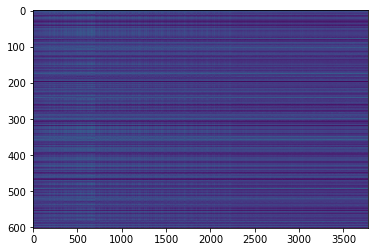

,AUC,pAUC
Source_0,0.795100,0.608421
Source_1,0.916700,0.794211
Source_2,0.823084,0.810489
Target_0,0.487400,0.480526
Target_1,0.652551,0.556069
Target_2,0.630142,0.519416
mean,0.717496,0.628189
h_mean,0.686923,0.603551


2021-05-26 23:08:11,829 - pytorch_modeler.py - INFO - epoch:33/300, train_losses:25809.041016, val_AUC_hmean:0.686923, val_pAUC_hmean:0.603551, best_flag:True
2021-05-26 23:08:11,830 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.31it/s]
2021-05-26 23:08:12,671 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.26it/s]
2021-05-26 23:08:12,891 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 209.8551025390625, KLd: 1.8089714050292969, center_loss: 207.93746948242188


100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-26 23:08:13,109 - pytorch_modeler.py - INFO - epoch:34/300, train_losses:25655.937988, val_AUC_hmean:0.689353, val_pAUC_hmean:0.595675, best_flag:False
2021-05-26 23:08:13,110 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.41it/s]
2021-05-26 23:08:13,945 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
2021-05-26 23:08:14,170 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 212.32081604003906, KLd: 1.8076543807983398, center_loss: 210.4091339111328


100%|██████████| 2/2 [00:00<00:00, 10.92it/s]
2021-05-26 23:08:14,382 - pytorch_modeler.py - INFO - epoch:35/300, train_losses:25600.818034, val_AUC_hmean:0.682988, val_pAUC_hmean:0.579806, best_flag:False
2021-05-26 23:08:14,383 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.07it/s]
2021-05-26 23:08:15,182 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.18it/s]
2021-05-26 23:08:15,408 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 206.0517578125, KLd: 1.585357904434204, center_loss: 204.35369873046875


100%|██████████| 2/2 [00:00<00:00,  9.52it/s]
2021-05-26 23:08:15,644 - pytorch_modeler.py - INFO - epoch:36/300, train_losses:25514.000000, val_AUC_hmean:0.688935, val_pAUC_hmean:0.595139, best_flag:False
2021-05-26 23:08:15,645 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.44it/s]
2021-05-26 23:08:16,478 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.39it/s]
2021-05-26 23:08:16,677 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 209.40374755859375, KLd: 1.5797492265701294, center_loss: 207.7140655517578


100%|██████████| 2/2 [00:00<00:00, 11.27it/s]
2021-05-26 23:08:16,881 - pytorch_modeler.py - INFO - epoch:37/300, train_losses:25425.278158, val_AUC_hmean:0.684609, val_pAUC_hmean:0.588511, best_flag:False
2021-05-26 23:08:16,883 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.75it/s]
2021-05-26 23:08:17,699 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.30it/s]
2021-05-26 23:08:17,897 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 206.11090087890625, KLd: 1.5477488040924072, center_loss: 204.45162963867188


100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
2021-05-26 23:08:18,117 - pytorch_modeler.py - INFO - epoch:38/300, train_losses:25310.650391, val_AUC_hmean:0.682859, val_pAUC_hmean:0.601593, best_flag:False
2021-05-26 23:08:18,118 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.10it/s]
2021-05-26 23:08:18,916 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.96it/s]
2021-05-26 23:08:19,124 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 208.28817749023438, KLd: 1.5034565925598145, center_loss: 206.6865234375


100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-26 23:08:19,332 - pytorch_modeler.py - INFO - epoch:39/300, train_losses:25288.902669, val_AUC_hmean:0.685716, val_pAUC_hmean:0.594591, best_flag:False
2021-05-26 23:08:19,334 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.01it/s]
2021-05-26 23:08:20,136 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.36it/s]
2021-05-26 23:08:20,352 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 206.53009033203125, KLd: 1.7731579542160034, center_loss: 204.65328979492188


100%|██████████| 2/2 [00:00<00:00, 10.80it/s]
2021-05-26 23:08:20,563 - pytorch_modeler.py - INFO - epoch:40/300, train_losses:25414.324219, val_AUC_hmean:0.699187, val_pAUC_hmean:0.603159, best_flag:False
2021-05-26 23:08:20,564 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.17it/s]
2021-05-26 23:08:21,359 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
2021-05-26 23:08:21,571 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 204.51699829101562, KLd: 1.5754095315933228, center_loss: 202.83871459960938


100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-26 23:08:21,791 - pytorch_modeler.py - INFO - epoch:41/300, train_losses:25197.797852, val_AUC_hmean:0.690201, val_pAUC_hmean:0.601652, best_flag:False
2021-05-26 23:08:21,792 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.10it/s]
2021-05-26 23:08:22,589 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.94it/s]
2021-05-26 23:08:22,796 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 207.00296020507812, KLd: 1.5438306331634521, center_loss: 205.35800170898438


100%|██████████| 2/2 [00:00<00:00,  9.80it/s]
2021-05-26 23:08:23,025 - pytorch_modeler.py - INFO - epoch:42/300, train_losses:25124.573568, val_AUC_hmean:0.684386, val_pAUC_hmean:0.591297, best_flag:False
2021-05-26 23:08:23,026 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.22it/s]
2021-05-26 23:08:23,816 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.44it/s]
2021-05-26 23:08:24,014 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 207.7138671875, KLd: 1.5250478982925415, center_loss: 206.073974609375


100%|██████████| 2/2 [00:00<00:00, 10.68it/s]
2021-05-26 23:08:24,228 - pytorch_modeler.py - INFO - epoch:43/300, train_losses:25027.804199, val_AUC_hmean:0.687229, val_pAUC_hmean:0.592738, best_flag:False
2021-05-26 23:08:24,229 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.30it/s]
2021-05-26 23:08:25,070 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.15it/s]
2021-05-26 23:08:25,290 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 206.63070678710938, KLd: 1.4561704397201538, center_loss: 205.07174682617188


100%|██████████| 2/2 [00:00<00:00, 10.59it/s]
2021-05-26 23:08:25,505 - pytorch_modeler.py - INFO - epoch:44/300, train_losses:24916.119466, val_AUC_hmean:0.693813, val_pAUC_hmean:0.598256, best_flag:False
2021-05-26 23:08:25,506 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.52it/s]
2021-05-26 23:08:26,281 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.80it/s]
2021-05-26 23:08:26,492 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 203.67166137695312, KLd: 1.4131284952163696, center_loss: 202.1655731201172


100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
2021-05-26 23:08:26,708 - pytorch_modeler.py - INFO - epoch:45/300, train_losses:24843.742513, val_AUC_hmean:0.689770, val_pAUC_hmean:0.596840, best_flag:False
2021-05-26 23:08:26,709 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.13it/s]
2021-05-26 23:08:27,505 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.97it/s]
2021-05-26 23:08:27,729 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 203.9151611328125, KLd: 1.3697142601013184, center_loss: 202.4490966796875


100%|██████████| 2/2 [00:00<00:00, 10.80it/s]
2021-05-26 23:08:27,946 - pytorch_modeler.py - INFO - epoch:46/300, train_losses:24806.804362, val_AUC_hmean:0.687944, val_pAUC_hmean:0.589770, best_flag:False
2021-05-26 23:08:27,948 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.26it/s]
2021-05-26 23:08:28,793 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.84it/s]
2021-05-26 23:08:29,026 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 204.3335723876953, KLd: 1.367426872253418, center_loss: 202.87374877929688


100%|██████████| 2/2 [00:00<00:00, 10.86it/s]
2021-05-26 23:08:29,246 - pytorch_modeler.py - INFO - epoch:47/300, train_losses:24753.035319, val_AUC_hmean:0.689962, val_pAUC_hmean:0.594062, best_flag:False
2021-05-26 23:08:29,247 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.52it/s]
2021-05-26 23:08:30,023 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-26 23:08:30,238 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 204.54031372070312, KLd: 1.3745296001434326, center_loss: 203.07339477539062


100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
2021-05-26 23:08:30,455 - pytorch_modeler.py - INFO - epoch:48/300, train_losses:24703.310710, val_AUC_hmean:0.687692, val_pAUC_hmean:0.594042, best_flag:False
2021-05-26 23:08:30,456 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.18it/s]
2021-05-26 23:08:31,250 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-26 23:08:31,451 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 204.0006866455078, KLd: 1.4057109355926514, center_loss: 202.51080322265625


100%|██████████| 2/2 [00:00<00:00, 11.02it/s]
2021-05-26 23:08:31,663 - pytorch_modeler.py - INFO - epoch:49/300, train_losses:24603.010905, val_AUC_hmean:0.684335, val_pAUC_hmean:0.593372, best_flag:False
2021-05-26 23:08:31,665 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.11it/s]
2021-05-26 23:08:32,518 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-26 23:08:32,728 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 202.73336791992188, KLd: 1.3491884469985962, center_loss: 201.29278564453125


100%|██████████| 2/2 [00:00<00:00, 11.23it/s]
2021-05-26 23:08:32,934 - pytorch_modeler.py - INFO - epoch:50/300, train_losses:24531.856283, val_AUC_hmean:0.694084, val_pAUC_hmean:0.593115, best_flag:False
2021-05-26 23:08:32,935 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.55it/s]
2021-05-26 23:08:33,709 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.86it/s]
2021-05-26 23:08:33,939 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 203.43423461914062, KLd: 1.3045530319213867, center_loss: 202.03138732910156


100%|██████████| 2/2 [00:00<00:00, 10.16it/s]
2021-05-26 23:08:34,161 - pytorch_modeler.py - INFO - epoch:51/300, train_losses:24494.863118, val_AUC_hmean:0.692475, val_pAUC_hmean:0.596942, best_flag:False
2021-05-26 23:08:34,162 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.18it/s]
2021-05-26 23:08:34,954 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.50it/s]
2021-05-26 23:08:35,189 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 202.5721893310547, KLd: 1.2978349924087524, center_loss: 201.18508911132812


100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
2021-05-26 23:08:35,394 - pytorch_modeler.py - INFO - epoch:52/300, train_losses:24406.092773, val_AUC_hmean:0.687433, val_pAUC_hmean:0.595075, best_flag:False
2021-05-26 23:08:35,396 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.66it/s]
2021-05-26 23:08:36,278 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.70it/s]
2021-05-26 23:08:36,509 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 200.90179443359375, KLd: 1.2528982162475586, center_loss: 199.5626220703125


100%|██████████| 2/2 [00:00<00:00,  9.67it/s]
2021-05-26 23:08:36,746 - pytorch_modeler.py - INFO - epoch:53/300, train_losses:24328.395508, val_AUC_hmean:0.698147, val_pAUC_hmean:0.593623, best_flag:False
2021-05-26 23:08:36,747 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.94it/s]
2021-05-26 23:08:37,553 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.53it/s]
2021-05-26 23:08:37,771 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 202.56787109375, KLd: 1.5422273874282837, center_loss: 200.93878173828125


100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
2021-05-26 23:08:37,991 - pytorch_modeler.py - INFO - epoch:54/300, train_losses:24364.143392, val_AUC_hmean:0.688768, val_pAUC_hmean:0.585930, best_flag:False
2021-05-26 23:08:37,992 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.37it/s]
2021-05-26 23:08:38,775 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.38it/s]
2021-05-26 23:08:38,991 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 199.6481475830078, KLd: 1.2613282203674316, center_loss: 198.30856323242188


100%|██████████| 2/2 [00:00<00:00, 10.01it/s]
2021-05-26 23:08:39,216 - pytorch_modeler.py - INFO - epoch:55/300, train_losses:24271.302083, val_AUC_hmean:0.687589, val_pAUC_hmean:0.594949, best_flag:False
2021-05-26 23:08:39,218 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.67it/s]
2021-05-26 23:08:40,098 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.98it/s]
2021-05-26 23:08:40,353 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 199.30679321289062, KLd: 1.2087173461914062, center_loss: 198.00814819335938


100%|██████████| 2/2 [00:00<00:00,  8.86it/s]
2021-05-26 23:08:40,604 - pytorch_modeler.py - INFO - epoch:56/300, train_losses:24216.097331, val_AUC_hmean:0.688029, val_pAUC_hmean:0.589733, best_flag:False
2021-05-26 23:08:40,605 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.13it/s]
2021-05-26 23:08:41,522 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.15it/s]
2021-05-26 23:08:41,769 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 201.41384887695312, KLd: 1.2870464324951172, center_loss: 200.03463745117188


100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
2021-05-26 23:08:41,994 - pytorch_modeler.py - INFO - epoch:57/300, train_losses:24125.243001, val_AUC_hmean:0.685129, val_pAUC_hmean:0.593749, best_flag:False
2021-05-26 23:08:41,995 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.33it/s]
2021-05-26 23:08:42,780 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-26 23:08:42,996 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 196.0751953125, KLd: 1.1722606420516968, center_loss: 194.81817626953125


100%|██████████| 2/2 [00:00<00:00,  9.39it/s]
2021-05-26 23:08:43,233 - pytorch_modeler.py - INFO - epoch:58/300, train_losses:24068.751790, val_AUC_hmean:0.693992, val_pAUC_hmean:0.593614, best_flag:False
2021-05-26 23:08:43,234 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.55it/s]
2021-05-26 23:08:44,060 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.55it/s]
2021-05-26 23:08:44,292 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 197.99436950683594, KLd: 1.177533745765686, center_loss: 196.72177124023438


100%|██████████| 2/2 [00:00<00:00, 10.75it/s]
2021-05-26 23:08:44,506 - pytorch_modeler.py - INFO - epoch:59/300, train_losses:24005.456055, val_AUC_hmean:0.686277, val_pAUC_hmean:0.592078, best_flag:False
2021-05-26 23:08:44,508 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.44it/s]
2021-05-26 23:08:45,342 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-26 23:08:45,549 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 197.5019073486328, KLd: 1.1540733575820923, center_loss: 196.270263671875


100%|██████████| 2/2 [00:00<00:00, 10.60it/s]
2021-05-26 23:08:45,765 - pytorch_modeler.py - INFO - epoch:60/300, train_losses:23955.997884, val_AUC_hmean:0.686057, val_pAUC_hmean:0.593859, best_flag:False
2021-05-26 23:08:45,767 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.51it/s]
2021-05-26 23:08:46,597 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.91it/s]
2021-05-26 23:08:46,803 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 197.70211791992188, KLd: 1.1167405843734741, center_loss: 196.50830078125


100%|██████████| 2/2 [00:00<00:00, 11.37it/s]
2021-05-26 23:08:47,007 - pytorch_modeler.py - INFO - epoch:61/300, train_losses:23885.384440, val_AUC_hmean:0.685712, val_pAUC_hmean:0.596809, best_flag:False
2021-05-26 23:08:47,008 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.65it/s]
2021-05-26 23:08:47,778 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.27it/s]
2021-05-26 23:08:47,994 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 200.0083770751953, KLd: 1.5254231691360474, center_loss: 198.389892578125


100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-26 23:08:48,199 - pytorch_modeler.py - INFO - epoch:62/300, train_losses:24006.805176, val_AUC_hmean:0.686644, val_pAUC_hmean:0.598049, best_flag:False
2021-05-26 23:08:48,200 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.44it/s]
2021-05-26 23:08:48,979 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.31it/s]
2021-05-26 23:08:49,198 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 201.46160888671875, KLd: 1.3587507009506226, center_loss: 200.01519775390625


100%|██████████| 2/2 [00:00<00:00, 11.15it/s]
2021-05-26 23:08:49,404 - pytorch_modeler.py - INFO - epoch:63/300, train_losses:23850.491862, val_AUC_hmean:0.680964, val_pAUC_hmean:0.587044, best_flag:False
2021-05-26 23:08:49,405 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.89it/s]
2021-05-26 23:08:50,214 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.28it/s]
2021-05-26 23:08:50,431 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 196.02276611328125, KLd: 1.1842985153198242, center_loss: 194.763427734375


100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
2021-05-26 23:08:50,645 - pytorch_modeler.py - INFO - epoch:64/300, train_losses:23754.762207, val_AUC_hmean:0.691160, val_pAUC_hmean:0.591046, best_flag:False
2021-05-26 23:08:50,647 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.45it/s]
2021-05-26 23:08:51,426 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.09it/s]
2021-05-26 23:08:51,633 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 195.9452667236328, KLd: 1.1642627716064453, center_loss: 194.69180297851562


100%|██████████| 2/2 [00:00<00:00, 11.34it/s]
2021-05-26 23:08:51,842 - pytorch_modeler.py - INFO - epoch:65/300, train_losses:23685.382487, val_AUC_hmean:0.692822, val_pAUC_hmean:0.596283, best_flag:False
2021-05-26 23:08:51,844 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.84it/s]
2021-05-26 23:08:52,655 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.85it/s]
2021-05-26 23:08:52,863 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 195.26919555664062, KLd: 1.1600966453552246, center_loss: 194.02789306640625


100%|██████████| 2/2 [00:00<00:00, 10.53it/s]
2021-05-26 23:08:53,081 - pytorch_modeler.py - INFO - epoch:66/300, train_losses:23607.484538, val_AUC_hmean:0.688686, val_pAUC_hmean:0.595576, best_flag:False
2021-05-26 23:08:53,082 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.76it/s]
2021-05-26 23:08:53,957 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.61it/s]
2021-05-26 23:08:54,171 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 195.35826110839844, KLd: 1.1085245609283447, center_loss: 194.1715087890625


100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-26 23:08:54,386 - pytorch_modeler.py - INFO - epoch:67/300, train_losses:23555.296061, val_AUC_hmean:0.692899, val_pAUC_hmean:0.595890, best_flag:False
2021-05-26 23:08:54,387 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.87it/s]
2021-05-26 23:08:55,196 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.99it/s]
2021-05-26 23:08:55,419 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 194.38232421875, KLd: 1.0852768421173096, center_loss: 193.22174072265625


100%|██████████| 2/2 [00:00<00:00, 10.48it/s]
2021-05-26 23:08:55,646 - pytorch_modeler.py - INFO - epoch:68/300, train_losses:23493.767253, val_AUC_hmean:0.691761, val_pAUC_hmean:0.597810, best_flag:False
2021-05-26 23:08:55,647 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.25it/s]
2021-05-26 23:08:56,437 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-26 23:08:56,645 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 194.3448944091797, KLd: 1.0497230291366577, center_loss: 193.22532653808594


100%|██████████| 2/2 [00:00<00:00, 10.98it/s]
2021-05-26 23:08:56,853 - pytorch_modeler.py - INFO - epoch:69/300, train_losses:23482.918294, val_AUC_hmean:0.689993, val_pAUC_hmean:0.592109, best_flag:False
2021-05-26 23:08:56,855 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.98it/s]
2021-05-26 23:08:57,715 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.63it/s]
2021-05-26 23:08:57,945 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 196.50128173828125, KLd: 1.1720664501190186, center_loss: 195.25625610351562


100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-26 23:08:58,163 - pytorch_modeler.py - INFO - epoch:70/300, train_losses:23423.826823, val_AUC_hmean:0.691776, val_pAUC_hmean:0.594909, best_flag:False
2021-05-26 23:08:58,164 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.71it/s]
2021-05-26 23:08:58,983 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
2021-05-26 23:08:59,204 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 193.21182250976562, KLd: 1.173421859741211, center_loss: 191.95236206054688


100%|██████████| 2/2 [00:00<00:00, 10.16it/s]
2021-05-26 23:08:59,429 - pytorch_modeler.py - INFO - epoch:71/300, train_losses:23460.728841, val_AUC_hmean:0.690893, val_pAUC_hmean:0.600156, best_flag:False
2021-05-26 23:08:59,431 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.41it/s]
2021-05-26 23:09:00,212 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.38it/s]
2021-05-26 23:09:00,429 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 191.24411010742188, KLd: 1.1795483827590942, center_loss: 189.9955596923828


100%|██████████| 2/2 [00:00<00:00,  9.56it/s]
2021-05-26 23:09:00,669 - pytorch_modeler.py - INFO - epoch:72/300, train_losses:23449.369303, val_AUC_hmean:0.685990, val_pAUC_hmean:0.580163, best_flag:False
2021-05-26 23:09:00,671 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.36it/s]
2021-05-26 23:09:01,572 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.92it/s]
2021-05-26 23:09:01,800 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 192.5594482421875, KLd: 1.2003815174102783, center_loss: 191.28936767578125


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


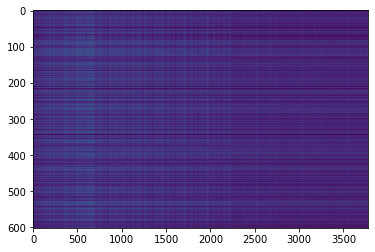

,AUC,pAUC
Source_0,0.773800,0.601579
Source_1,0.910800,0.784211
Source_2,0.830838,0.807674
Target_0,0.496000,0.480000
Target_1,0.670816,0.588829
Target_2,0.611976,0.512738
mean,0.715705,0.629172
h_mean,0.686910,0.605601


2021-05-26 23:09:03,346 - pytorch_modeler.py - INFO - epoch:73/300, train_losses:23330.697428, val_AUC_hmean:0.686910, val_pAUC_hmean:0.605601, best_flag:True
2021-05-26 23:09:03,347 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.82it/s]
2021-05-26 23:09:04,218 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.73it/s]
2021-05-26 23:09:04,499 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 189.64016723632812, KLd: 1.0823547840118408, center_loss: 188.48748779296875


100%|██████████| 2/2 [00:00<00:00, 10.43it/s]
2021-05-26 23:09:04,718 - pytorch_modeler.py - INFO - epoch:74/300, train_losses:23237.763672, val_AUC_hmean:0.695825, val_pAUC_hmean:0.589547, best_flag:False
2021-05-26 23:09:04,720 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.95it/s]
2021-05-26 23:09:05,582 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-26 23:09:05,795 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 191.28656005859375, KLd: 1.0285837650299072, center_loss: 190.178955078125


100%|██████████| 2/2 [00:00<00:00, 10.22it/s]
2021-05-26 23:09:06,019 - pytorch_modeler.py - INFO - epoch:75/300, train_losses:23168.775391, val_AUC_hmean:0.691438, val_pAUC_hmean:0.599719, best_flag:False
2021-05-26 23:09:06,021 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.76it/s]
2021-05-26 23:09:06,836 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.25it/s]
2021-05-26 23:09:07,053 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 190.4838409423828, KLd: 0.9785920977592468, center_loss: 189.43075561523438


100%|██████████| 2/2 [00:00<00:00,  9.83it/s]
2021-05-26 23:09:07,281 - pytorch_modeler.py - INFO - epoch:76/300, train_losses:23070.555013, val_AUC_hmean:0.695180, val_pAUC_hmean:0.589800, best_flag:False
2021-05-26 23:09:07,283 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.93it/s]
2021-05-26 23:09:08,090 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.63it/s]
2021-05-26 23:09:08,301 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 191.14407348632812, KLd: 1.104262113571167, center_loss: 189.9635467529297


100%|██████████| 2/2 [00:00<00:00,  9.09it/s]
2021-05-26 23:09:08,545 - pytorch_modeler.py - INFO - epoch:77/300, train_losses:23050.710124, val_AUC_hmean:0.690362, val_pAUC_hmean:0.597495, best_flag:False
2021-05-26 23:09:08,546 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.45it/s]
2021-05-26 23:09:09,441 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.10it/s]
2021-05-26 23:09:09,662 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 189.7073974609375, KLd: 1.0198163986206055, center_loss: 188.62161254882812


100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-26 23:09:09,884 - pytorch_modeler.py - INFO - epoch:78/300, train_losses:22918.687663, val_AUC_hmean:0.692098, val_pAUC_hmean:0.597013, best_flag:False
2021-05-26 23:09:09,886 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.36it/s]
2021-05-26 23:09:10,669 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.95it/s]
2021-05-26 23:09:10,898 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 188.26708984375, KLd: 0.9990029335021973, center_loss: 187.1996307373047


100%|██████████| 2/2 [00:00<00:00,  9.75it/s]
2021-05-26 23:09:11,128 - pytorch_modeler.py - INFO - epoch:79/300, train_losses:22882.732259, val_AUC_hmean:0.689969, val_pAUC_hmean:0.596050, best_flag:False
2021-05-26 23:09:11,129 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.04it/s]
2021-05-26 23:09:11,929 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.63it/s]
2021-05-26 23:09:12,152 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 189.97813415527344, KLd: 0.9899062514305115, center_loss: 188.92047119140625


100%|██████████| 2/2 [00:00<00:00, 10.77it/s]
2021-05-26 23:09:12,374 - pytorch_modeler.py - INFO - epoch:80/300, train_losses:22886.735840, val_AUC_hmean:0.686743, val_pAUC_hmean:0.596579, best_flag:False
2021-05-26 23:09:12,375 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.78it/s]
2021-05-26 23:09:13,249 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.25it/s]
2021-05-26 23:09:13,490 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 188.58001708984375, KLd: 0.9667078256607056, center_loss: 187.5546875


100%|██████████| 2/2 [00:00<00:00,  9.74it/s]
2021-05-26 23:09:13,721 - pytorch_modeler.py - INFO - epoch:81/300, train_losses:22788.433268, val_AUC_hmean:0.688841, val_pAUC_hmean:0.595454, best_flag:False
2021-05-26 23:09:13,722 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.95it/s]
2021-05-26 23:09:14,527 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.15it/s]
2021-05-26 23:09:14,773 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 188.9393310546875, KLd: 0.968066930770874, center_loss: 187.90423583984375


100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-26 23:09:14,984 - pytorch_modeler.py - INFO - epoch:82/300, train_losses:22760.342611, val_AUC_hmean:0.686820, val_pAUC_hmean:0.598528, best_flag:False
2021-05-26 23:09:14,986 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.53it/s]
2021-05-26 23:09:15,815 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:09:16,037 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 186.914306640625, KLd: 0.9406818151473999, center_loss: 185.90615844726562


100%|██████████| 2/2 [00:00<00:00, 10.93it/s]
2021-05-26 23:09:16,251 - pytorch_modeler.py - INFO - epoch:83/300, train_losses:22676.887044, val_AUC_hmean:0.689636, val_pAUC_hmean:0.599902, best_flag:False
2021-05-26 23:09:16,252 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.94it/s]
2021-05-26 23:09:17,058 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.82it/s]
2021-05-26 23:09:17,267 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 187.26983642578125, KLd: 0.9065091609954834, center_loss: 186.2987518310547


100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-26 23:09:17,484 - pytorch_modeler.py - INFO - epoch:84/300, train_losses:22612.987467, val_AUC_hmean:0.694008, val_pAUC_hmean:0.600777, best_flag:False
2021-05-26 23:09:17,485 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.57it/s]
2021-05-26 23:09:18,371 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
2021-05-26 23:09:18,589 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 185.40008544921875, KLd: 0.8742150068283081, center_loss: 184.46055603027344


100%|██████████| 2/2 [00:00<00:00, 10.29it/s]
2021-05-26 23:09:18,810 - pytorch_modeler.py - INFO - epoch:85/300, train_losses:22567.984375, val_AUC_hmean:0.696199, val_pAUC_hmean:0.599359, best_flag:False
2021-05-26 23:09:18,811 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.84it/s]
2021-05-26 23:09:19,623 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.49it/s]
2021-05-26 23:09:19,862 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 185.61647033691406, KLd: 0.902073860168457, center_loss: 184.649169921875


100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
2021-05-26 23:09:20,059 - pytorch_modeler.py - INFO - epoch:86/300, train_losses:22523.406087, val_AUC_hmean:0.690547, val_pAUC_hmean:0.594845, best_flag:False
2021-05-26 23:09:20,060 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 16.47it/s]
2021-05-26 23:09:20,791 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.90it/s]
2021-05-26 23:09:21,037 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 187.33697509765625, KLd: 0.9425715208053589, center_loss: 186.32110595703125


100%|██████████| 2/2 [00:00<00:00, 11.47it/s]
2021-05-26 23:09:21,236 - pytorch_modeler.py - INFO - epoch:87/300, train_losses:22559.854818, val_AUC_hmean:0.689644, val_pAUC_hmean:0.590503, best_flag:False
2021-05-26 23:09:21,237 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.66it/s]
2021-05-26 23:09:21,794 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.71it/s]
2021-05-26 23:09:22,048 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 186.97386169433594, KLd: 1.048372507095337, center_loss: 185.85775756835938


100%|██████████| 2/2 [00:00<00:00, 10.82it/s]
2021-05-26 23:09:22,260 - pytorch_modeler.py - INFO - epoch:88/300, train_losses:22479.753255, val_AUC_hmean:0.691028, val_pAUC_hmean:0.598795, best_flag:False
2021-05-26 23:09:22,262 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.78it/s]
2021-05-26 23:09:23,076 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.82it/s]
2021-05-26 23:09:23,304 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 185.13247680664062, KLd: 1.0225681066513062, center_loss: 184.0408172607422


100%|██████████| 2/2 [00:00<00:00, 11.55it/s]
2021-05-26 23:09:23,508 - pytorch_modeler.py - INFO - epoch:89/300, train_losses:22416.862793, val_AUC_hmean:0.696286, val_pAUC_hmean:0.596247, best_flag:False
2021-05-26 23:09:23,509 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.19it/s]
2021-05-26 23:09:24,078 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
2021-05-26 23:09:24,276 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 184.11178588867188, KLd: 0.944733202457428, center_loss: 183.1016845703125


100%|██████████| 2/2 [00:00<00:00,  9.69it/s]
2021-05-26 23:09:24,507 - pytorch_modeler.py - INFO - epoch:90/300, train_losses:22378.576823, val_AUC_hmean:0.690980, val_pAUC_hmean:0.590556, best_flag:False
2021-05-26 23:09:24,508 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 16.61it/s]
2021-05-26 23:09:25,233 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.41it/s]
2021-05-26 23:09:25,428 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 183.77175903320312, KLd: 0.9612225294113159, center_loss: 182.7496337890625


100%|██████████| 2/2 [00:00<00:00, 11.07it/s]
2021-05-26 23:09:25,633 - pytorch_modeler.py - INFO - epoch:91/300, train_losses:22291.395020, val_AUC_hmean:0.687124, val_pAUC_hmean:0.592288, best_flag:False
2021-05-26 23:09:25,634 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.56it/s]
2021-05-26 23:09:26,194 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
2021-05-26 23:09:26,413 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 186.7548065185547, KLd: 0.9780261516571045, center_loss: 185.72174072265625


100%|██████████| 2/2 [00:00<00:00,  9.99it/s]
2021-05-26 23:09:26,638 - pytorch_modeler.py - INFO - epoch:92/300, train_losses:22245.976725, val_AUC_hmean:0.683977, val_pAUC_hmean:0.602891, best_flag:False
2021-05-26 23:09:26,639 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.29it/s]
2021-05-26 23:09:27,205 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.32it/s]
2021-05-26 23:09:27,405 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 186.75282287597656, KLd: 0.9601026177406311, center_loss: 185.7296142578125


100%|██████████| 2/2 [00:00<00:00, 11.62it/s]
2021-05-26 23:09:27,602 - pytorch_modeler.py - INFO - epoch:93/300, train_losses:22200.497233, val_AUC_hmean:0.687520, val_pAUC_hmean:0.598524, best_flag:False
2021-05-26 23:09:27,603 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.38it/s]
2021-05-26 23:09:28,386 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.98it/s]
2021-05-26 23:09:28,610 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 183.02976989746094, KLd: 0.9098927974700928, center_loss: 182.05307006835938


100%|██████████| 2/2 [00:00<00:00, 10.31it/s]
2021-05-26 23:09:28,832 - pytorch_modeler.py - INFO - epoch:94/300, train_losses:22140.911621, val_AUC_hmean:0.697054, val_pAUC_hmean:0.595449, best_flag:False
2021-05-26 23:09:28,833 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.21it/s]
2021-05-26 23:09:29,625 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.92it/s]
2021-05-26 23:09:29,848 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 182.89581298828125, KLd: 0.8676344752311707, center_loss: 181.96730041503906


100%|██████████| 2/2 [00:00<00:00,  9.67it/s]
2021-05-26 23:09:30,080 - pytorch_modeler.py - INFO - epoch:95/300, train_losses:22063.419759, val_AUC_hmean:0.693677, val_pAUC_hmean:0.597410, best_flag:False
2021-05-26 23:09:30,081 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.56it/s]
2021-05-26 23:09:30,640 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.51it/s]
2021-05-26 23:09:30,834 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 182.08030700683594, KLd: 0.8521131277084351, center_loss: 181.16943359375


100%|██████████| 2/2 [00:00<00:00, 11.49it/s]
2021-05-26 23:09:31,036 - pytorch_modeler.py - INFO - epoch:96/300, train_losses:22033.769043, val_AUC_hmean:0.692571, val_pAUC_hmean:0.601333, best_flag:False
2021-05-26 23:09:31,037 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.73it/s]
2021-05-26 23:09:31,915 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.58it/s]
2021-05-26 23:09:32,147 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 182.93551635742188, KLd: 0.841234564781189, center_loss: 182.0396270751953


100%|██████████| 2/2 [00:00<00:00,  8.82it/s]
2021-05-26 23:09:32,404 - pytorch_modeler.py - INFO - epoch:97/300, train_losses:21964.711589, val_AUC_hmean:0.688912, val_pAUC_hmean:0.597616, best_flag:False
2021-05-26 23:09:32,405 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.83it/s]
2021-05-26 23:09:32,984 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.68it/s]
2021-05-26 23:09:33,197 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 181.897705078125, KLd: 0.8080406188964844, center_loss: 181.03289794921875


100%|██████████| 2/2 [00:00<00:00, 10.13it/s]
2021-05-26 23:09:33,418 - pytorch_modeler.py - INFO - epoch:98/300, train_losses:21909.737142, val_AUC_hmean:0.691796, val_pAUC_hmean:0.594826, best_flag:False
2021-05-26 23:09:33,419 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.68it/s]
2021-05-26 23:09:34,187 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.25it/s]
2021-05-26 23:09:34,406 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 180.64956665039062, KLd: 0.792266845703125, center_loss: 179.79159545898438


100%|██████████| 2/2 [00:00<00:00,  9.65it/s]
2021-05-26 23:09:34,640 - pytorch_modeler.py - INFO - epoch:99/300, train_losses:21858.932943, val_AUC_hmean:0.692074, val_pAUC_hmean:0.594056, best_flag:False
2021-05-26 23:09:34,641 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.47it/s]
2021-05-26 23:09:35,203 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.77it/s]
2021-05-26 23:09:35,428 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 181.15597534179688, KLd: 0.7972497940063477, center_loss: 180.29476928710938


100%|██████████| 2/2 [00:00<00:00, 11.49it/s]
2021-05-26 23:09:35,633 - pytorch_modeler.py - INFO - epoch:100/300, train_losses:21818.872070, val_AUC_hmean:0.694517, val_pAUC_hmean:0.594007, best_flag:False
2021-05-26 23:09:35,634 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.25it/s]
2021-05-26 23:09:36,478 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
2021-05-26 23:09:36,695 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 180.17544555664062, KLd: 0.8085638284683228, center_loss: 179.319580078125


100%|██████████| 2/2 [00:00<00:00,  9.74it/s]
2021-05-26 23:09:36,926 - pytorch_modeler.py - INFO - epoch:101/300, train_losses:21762.950033, val_AUC_hmean:0.695109, val_pAUC_hmean:0.597862, best_flag:False
2021-05-26 23:09:36,927 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.97it/s]
2021-05-26 23:09:37,731 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
2021-05-26 23:09:37,935 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 180.8837127685547, KLd: 0.8192750811576843, center_loss: 180.010986328125


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]
2021-05-26 23:09:38,193 - pytorch_modeler.py - INFO - epoch:102/300, train_losses:21726.523600, val_AUC_hmean:0.696469, val_pAUC_hmean:0.598997, best_flag:False
2021-05-26 23:09:38,194 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 16.04it/s]
2021-05-26 23:09:38,944 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
2021-05-26 23:09:39,166 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 180.42640686035156, KLd: 0.814202606678009, center_loss: 179.55963134765625


100%|██████████| 2/2 [00:00<00:00, 11.24it/s]
2021-05-26 23:09:39,374 - pytorch_modeler.py - INFO - epoch:103/300, train_losses:21684.934082, val_AUC_hmean:0.690272, val_pAUC_hmean:0.595795, best_flag:False
2021-05-26 23:09:39,375 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.45it/s]
2021-05-26 23:09:39,964 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.13it/s]
2021-05-26 23:09:40,213 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 180.07962036132812, KLd: 0.8246501684188843, center_loss: 179.20538330078125


100%|██████████| 2/2 [00:00<00:00, 10.30it/s]
2021-05-26 23:09:40,437 - pytorch_modeler.py - INFO - epoch:104/300, train_losses:21612.214193, val_AUC_hmean:0.693454, val_pAUC_hmean:0.600941, best_flag:False
2021-05-26 23:09:40,438 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.71it/s]
2021-05-26 23:09:41,316 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.16it/s]
2021-05-26 23:09:41,560 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 178.89468383789062, KLd: 0.8004234433174133, center_loss: 178.04449462890625


100%|██████████| 2/2 [00:00<00:00, 10.28it/s]
2021-05-26 23:09:41,783 - pytorch_modeler.py - INFO - epoch:105/300, train_losses:21579.378418, val_AUC_hmean:0.695403, val_pAUC_hmean:0.599380, best_flag:False
2021-05-26 23:09:41,785 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.16it/s]
2021-05-26 23:09:42,580 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.74it/s]
2021-05-26 23:09:42,808 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 180.05557250976562, KLd: 0.809819221496582, center_loss: 179.19796752929688


100%|██████████| 2/2 [00:00<00:00,  9.90it/s]
2021-05-26 23:09:43,034 - pytorch_modeler.py - INFO - epoch:106/300, train_losses:21537.520345, val_AUC_hmean:0.691110, val_pAUC_hmean:0.596315, best_flag:False
2021-05-26 23:09:43,036 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.30it/s]
2021-05-26 23:09:43,601 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.79it/s]
2021-05-26 23:09:43,828 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 179.2911834716797, KLd: 0.797303318977356, center_loss: 178.44271850585938


100%|██████████| 2/2 [00:00<00:00,  9.94it/s]
2021-05-26 23:09:44,054 - pytorch_modeler.py - INFO - epoch:107/300, train_losses:21499.238444, val_AUC_hmean:0.692908, val_pAUC_hmean:0.598856, best_flag:False
2021-05-26 23:09:44,055 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.02it/s]
2021-05-26 23:09:44,861 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.30it/s]
2021-05-26 23:09:45,079 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 178.14581298828125, KLd: 0.7978118658065796, center_loss: 177.28558349609375


100%|██████████| 2/2 [00:00<00:00, 10.13it/s]
2021-05-26 23:09:45,306 - pytorch_modeler.py - INFO - epoch:108/300, train_losses:21442.327962, val_AUC_hmean:0.692761, val_pAUC_hmean:0.599767, best_flag:False
2021-05-26 23:09:45,307 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.15it/s]
2021-05-26 23:09:46,158 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.21it/s]
2021-05-26 23:09:46,385 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 177.61279296875, KLd: 0.770193338394165, center_loss: 176.789794921875


100%|██████████| 2/2 [00:00<00:00,  9.42it/s]
2021-05-26 23:09:46,621 - pytorch_modeler.py - INFO - epoch:109/300, train_losses:21383.583822, val_AUC_hmean:0.699715, val_pAUC_hmean:0.594595, best_flag:False
2021-05-26 23:09:46,622 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.23it/s]
2021-05-26 23:09:47,190 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.81it/s]
2021-05-26 23:09:47,417 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 177.3016357421875, KLd: 0.7627132534980774, center_loss: 176.48219299316406


100%|██████████| 2/2 [00:00<00:00,  9.94it/s]
2021-05-26 23:09:47,644 - pytorch_modeler.py - INFO - epoch:110/300, train_losses:21353.595052, val_AUC_hmean:0.692269, val_pAUC_hmean:0.585116, best_flag:False
2021-05-26 23:09:47,645 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.67it/s]
2021-05-26 23:09:48,413 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
2021-05-26 23:09:48,622 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 176.7206573486328, KLd: 0.7792996168136597, center_loss: 175.8959197998047


100%|██████████| 2/2 [00:00<00:00,  9.86it/s]
2021-05-26 23:09:48,852 - pytorch_modeler.py - INFO - epoch:111/300, train_losses:21315.537272, val_AUC_hmean:0.693792, val_pAUC_hmean:0.595412, best_flag:False
2021-05-26 23:09:48,853 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.93it/s]
2021-05-26 23:09:49,717 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.50it/s]
2021-05-26 23:09:49,951 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 176.54449462890625, KLd: 0.7607126235961914, center_loss: 175.73292541503906


100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-26 23:09:50,157 - pytorch_modeler.py - INFO - epoch:112/300, train_losses:21251.733724, val_AUC_hmean:0.696142, val_pAUC_hmean:0.601516, best_flag:False
2021-05-26 23:09:50,159 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.38it/s]
2021-05-26 23:09:50,723 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.46it/s]
2021-05-26 23:09:50,961 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 177.4380645751953, KLd: 0.7719110250473022, center_loss: 176.62054443359375


100%|██████████| 2/2 [00:00<00:00,  9.89it/s]
2021-05-26 23:09:51,188 - pytorch_modeler.py - INFO - epoch:113/300, train_losses:21198.540690, val_AUC_hmean:0.691228, val_pAUC_hmean:0.597285, best_flag:False
2021-05-26 23:09:51,190 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.48it/s]
2021-05-26 23:09:52,021 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
2021-05-26 23:09:52,222 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 177.88247680664062, KLd: 0.78023362159729, center_loss: 177.05270385742188


100%|██████████| 2/2 [00:00<00:00, 11.47it/s]
2021-05-26 23:09:52,425 - pytorch_modeler.py - INFO - epoch:114/300, train_losses:21142.195801, val_AUC_hmean:0.691197, val_pAUC_hmean:0.596292, best_flag:False
2021-05-26 23:09:52,426 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.44it/s]
2021-05-26 23:09:52,963 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.04it/s]
2021-05-26 23:09:53,150 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 176.53121948242188, KLd: 0.7889406085014343, center_loss: 175.6929931640625


100%|██████████| 2/2 [00:00<00:00, 10.76it/s]
2021-05-26 23:09:53,364 - pytorch_modeler.py - INFO - epoch:115/300, train_losses:21171.269043, val_AUC_hmean:0.697393, val_pAUC_hmean:0.591241, best_flag:False
2021-05-26 23:09:53,365 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.94it/s]
2021-05-26 23:09:54,171 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.51it/s]
2021-05-26 23:09:54,383 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 174.19644165039062, KLd: 0.7670546770095825, center_loss: 173.3726348876953


100%|██████████| 2/2 [00:00<00:00,  9.32it/s]
2021-05-26 23:09:54,623 - pytorch_modeler.py - INFO - epoch:116/300, train_losses:21075.468099, val_AUC_hmean:0.696217, val_pAUC_hmean:0.597236, best_flag:False
2021-05-26 23:09:54,624 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.58it/s]
2021-05-26 23:09:55,184 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.37it/s]
2021-05-26 23:09:55,419 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 174.83782958984375, KLd: 0.7811036109924316, center_loss: 174.01248168945312


100%|██████████| 2/2 [00:00<00:00, 11.59it/s]
2021-05-26 23:09:55,619 - pytorch_modeler.py - INFO - epoch:117/300, train_losses:21026.082194, val_AUC_hmean:0.693934, val_pAUC_hmean:0.595685, best_flag:False
2021-05-26 23:09:55,620 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.86it/s]
2021-05-26 23:09:56,488 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.65it/s]
2021-05-26 23:09:56,716 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 175.78005981445312, KLd: 0.7863076329231262, center_loss: 174.95111083984375


100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-26 23:09:56,926 - pytorch_modeler.py - INFO - epoch:118/300, train_losses:20979.568359, val_AUC_hmean:0.692755, val_pAUC_hmean:0.596526, best_flag:False
2021-05-26 23:09:56,927 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.87it/s]
2021-05-26 23:09:57,736 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-26 23:09:57,958 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 175.66665649414062, KLd: 0.7759828567504883, center_loss: 174.8423614501953


100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
2021-05-26 23:09:58,179 - pytorch_modeler.py - INFO - epoch:119/300, train_losses:20926.639486, val_AUC_hmean:0.695602, val_pAUC_hmean:0.594737, best_flag:False
2021-05-26 23:09:58,180 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.72it/s]
2021-05-26 23:09:58,997 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.17it/s]
2021-05-26 23:09:59,199 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 176.06378173828125, KLd: 0.7856699228286743, center_loss: 175.22581481933594


100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-26 23:09:59,415 - pytorch_modeler.py - INFO - epoch:120/300, train_losses:20894.260905, val_AUC_hmean:0.699222, val_pAUC_hmean:0.591606, best_flag:False
2021-05-26 23:09:59,417 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.43it/s]
2021-05-26 23:10:00,251 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.78it/s]
2021-05-26 23:10:00,506 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 174.01365661621094, KLd: 0.7380624413490295, center_loss: 173.2278594970703


100%|██████████| 2/2 [00:00<00:00,  9.20it/s]
2021-05-26 23:10:00,754 - pytorch_modeler.py - INFO - epoch:121/300, train_losses:20828.576986, val_AUC_hmean:0.696034, val_pAUC_hmean:0.600398, best_flag:False
2021-05-26 23:10:00,755 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.78it/s]
2021-05-26 23:10:01,629 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:10:01,854 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 172.70974731445312, KLd: 0.762660026550293, center_loss: 171.90283203125


100%|██████████| 2/2 [00:00<00:00, 10.97it/s]
2021-05-26 23:10:02,061 - pytorch_modeler.py - INFO - epoch:122/300, train_losses:20810.559570, val_AUC_hmean:0.693010, val_pAUC_hmean:0.600097, best_flag:False
2021-05-26 23:10:02,062 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.85it/s]
2021-05-26 23:10:02,875 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.24it/s]
2021-05-26 23:10:03,094 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 173.70819091796875, KLd: 0.7731670141220093, center_loss: 172.8914337158203


100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
2021-05-26 23:10:03,308 - pytorch_modeler.py - INFO - epoch:123/300, train_losses:20796.293132, val_AUC_hmean:0.698416, val_pAUC_hmean:0.592068, best_flag:False
2021-05-26 23:10:03,309 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.85it/s]
2021-05-26 23:10:04,120 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.33it/s]
2021-05-26 23:10:04,335 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 174.77642822265625, KLd: 0.8499021530151367, center_loss: 173.88275146484375


100%|██████████| 2/2 [00:00<00:00, 10.05it/s]
2021-05-26 23:10:04,573 - pytorch_modeler.py - INFO - epoch:124/300, train_losses:20753.469889, val_AUC_hmean:0.687216, val_pAUC_hmean:0.589868, best_flag:False
2021-05-26 23:10:04,575 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.59it/s]
2021-05-26 23:10:05,460 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-26 23:10:05,679 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 174.34646606445312, KLd: 0.9659278988838196, center_loss: 173.33511352539062


100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
2021-05-26 23:10:05,905 - pytorch_modeler.py - INFO - epoch:125/300, train_losses:20738.476562, val_AUC_hmean:0.694692, val_pAUC_hmean:0.593900, best_flag:False
2021-05-26 23:10:05,906 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.23it/s]
2021-05-26 23:10:06,751 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.80it/s]
2021-05-26 23:10:07,001 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 174.396240234375, KLd: 0.8257268667221069, center_loss: 173.52597045898438


100%|██████████| 2/2 [00:00<00:00, 10.28it/s]
2021-05-26 23:10:07,224 - pytorch_modeler.py - INFO - epoch:126/300, train_losses:20659.441895, val_AUC_hmean:0.692790, val_pAUC_hmean:0.602842, best_flag:False
2021-05-26 23:10:07,226 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.89it/s]
2021-05-26 23:10:08,034 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.97it/s]
2021-05-26 23:10:08,256 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 173.14083862304688, KLd: 0.7887234687805176, center_loss: 172.3092041015625


100%|██████████| 2/2 [00:00<00:00, 10.54it/s]
2021-05-26 23:10:08,479 - pytorch_modeler.py - INFO - epoch:127/300, train_losses:20603.946126, val_AUC_hmean:0.690781, val_pAUC_hmean:0.596179, best_flag:False
2021-05-26 23:10:08,481 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.02it/s]
2021-05-26 23:10:09,339 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.55it/s]
2021-05-26 23:10:09,578 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 174.452392578125, KLd: 0.7823206782341003, center_loss: 173.6279296875


100%|██████████| 2/2 [00:00<00:00,  9.70it/s]
2021-05-26 23:10:09,811 - pytorch_modeler.py - INFO - epoch:128/300, train_losses:20545.174316, val_AUC_hmean:0.688076, val_pAUC_hmean:0.594534, best_flag:False
2021-05-26 23:10:09,812 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.88it/s]
2021-05-26 23:10:10,679 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.20it/s]
2021-05-26 23:10:10,895 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 171.8804473876953, KLd: 0.7481498122215271, center_loss: 171.09239196777344


100%|██████████| 2/2 [00:00<00:00, 10.78it/s]
2021-05-26 23:10:11,107 - pytorch_modeler.py - INFO - epoch:129/300, train_losses:20487.703125, val_AUC_hmean:0.689638, val_pAUC_hmean:0.598972, best_flag:False
2021-05-26 23:10:11,108 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 18.89it/s]
2021-05-26 23:10:11,746 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.34it/s]
2021-05-26 23:10:11,967 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 171.45751953125, KLd: 0.731597363948822, center_loss: 170.679931640625


100%|██████████| 2/2 [00:00<00:00,  9.65it/s]
2021-05-26 23:10:12,209 - pytorch_modeler.py - INFO - epoch:130/300, train_losses:20441.937174, val_AUC_hmean:0.689112, val_pAUC_hmean:0.599319, best_flag:False
2021-05-26 23:10:12,211 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 17.32it/s]
2021-05-26 23:10:12,906 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.14it/s]
2021-05-26 23:10:13,127 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 170.39898681640625, KLd: 0.7266864776611328, center_loss: 169.63137817382812


100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
2021-05-26 23:10:13,337 - pytorch_modeler.py - INFO - epoch:131/300, train_losses:20404.166829, val_AUC_hmean:0.692707, val_pAUC_hmean:0.593738, best_flag:False
2021-05-26 23:10:13,338 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.97it/s]
2021-05-26 23:10:14,143 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.97it/s]
2021-05-26 23:10:14,365 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 170.2510986328125, KLd: 0.7245458960533142, center_loss: 169.48141479492188


100%|██████████| 2/2 [00:00<00:00, 10.08it/s]
2021-05-26 23:10:14,588 - pytorch_modeler.py - INFO - epoch:132/300, train_losses:20376.383789, val_AUC_hmean:0.692599, val_pAUC_hmean:0.595729, best_flag:False
2021-05-26 23:10:14,589 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.30it/s]
2021-05-26 23:10:15,431 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
2021-05-26 23:10:15,641 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 170.5449676513672, KLd: 0.6823368668556213, center_loss: 169.822265625


100%|██████████| 2/2 [00:00<00:00, 10.97it/s]
2021-05-26 23:10:15,849 - pytorch_modeler.py - INFO - epoch:133/300, train_losses:20317.980632, val_AUC_hmean:0.695933, val_pAUC_hmean:0.595971, best_flag:False
2021-05-26 23:10:15,850 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.01it/s]
2021-05-26 23:10:16,652 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.48it/s]
2021-05-26 23:10:16,869 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 168.60983276367188, KLd: 0.6824729442596436, center_loss: 167.885009765625


100%|██████████| 2/2 [00:00<00:00, 10.69it/s]
2021-05-26 23:10:17,084 - pytorch_modeler.py - INFO - epoch:134/300, train_losses:20270.552572, val_AUC_hmean:0.697921, val_pAUC_hmean:0.593861, best_flag:False
2021-05-26 23:10:17,086 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.94it/s]
2021-05-26 23:10:17,891 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.66it/s]
2021-05-26 23:10:18,104 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 169.69737243652344, KLd: 0.6924610733985901, center_loss: 168.96212768554688


100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-26 23:10:18,312 - pytorch_modeler.py - INFO - epoch:135/300, train_losses:20223.623698, val_AUC_hmean:0.693403, val_pAUC_hmean:0.593232, best_flag:False
2021-05-26 23:10:18,313 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.76it/s]
2021-05-26 23:10:19,187 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.37it/s]
2021-05-26 23:10:19,421 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 169.19314575195312, KLd: 0.6830381155014038, center_loss: 168.4718017578125


100%|██████████| 2/2 [00:00<00:00, 10.54it/s]
2021-05-26 23:10:19,636 - pytorch_modeler.py - INFO - epoch:136/300, train_losses:20209.236165, val_AUC_hmean:0.696654, val_pAUC_hmean:0.598118, best_flag:False
2021-05-26 23:10:19,637 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.03it/s]
2021-05-26 23:10:20,495 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.09it/s]
2021-05-26 23:10:20,697 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 168.33616638183594, KLd: 0.6691070795059204, center_loss: 167.62258911132812


100%|██████████| 2/2 [00:00<00:00, 10.99it/s]
2021-05-26 23:10:20,905 - pytorch_modeler.py - INFO - epoch:137/300, train_losses:20164.623698, val_AUC_hmean:0.694121, val_pAUC_hmean:0.596471, best_flag:False
2021-05-26 23:10:20,906 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.91it/s]
2021-05-26 23:10:21,713 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.08it/s]
2021-05-26 23:10:21,917 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 170.18655395507812, KLd: 0.7170560359954834, center_loss: 169.41366577148438


100%|██████████| 2/2 [00:00<00:00,  9.57it/s]
2021-05-26 23:10:22,150 - pytorch_modeler.py - INFO - epoch:138/300, train_losses:20113.505371, val_AUC_hmean:0.687498, val_pAUC_hmean:0.591530, best_flag:False
2021-05-26 23:10:22,151 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.94it/s]
2021-05-26 23:10:22,700 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.23it/s]
2021-05-26 23:10:22,939 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 169.50717163085938, KLd: 0.678236186504364, center_loss: 168.77798461914062


100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
2021-05-26 23:10:23,144 - pytorch_modeler.py - INFO - epoch:139/300, train_losses:20062.153646, val_AUC_hmean:0.691442, val_pAUC_hmean:0.594406, best_flag:False
2021-05-26 23:10:23,145 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.40it/s]
2021-05-26 23:10:23,980 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
2021-05-26 23:10:24,201 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 168.89894104003906, KLd: 0.6943141222000122, center_loss: 168.161865234375


100%|██████████| 2/2 [00:00<00:00, 10.13it/s]
2021-05-26 23:10:24,425 - pytorch_modeler.py - INFO - epoch:140/300, train_losses:20016.188314, val_AUC_hmean:0.693991, val_pAUC_hmean:0.596674, best_flag:False
2021-05-26 23:10:24,426 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.53it/s]
2021-05-26 23:10:25,201 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.26it/s]
2021-05-26 23:10:25,424 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 168.25885009765625, KLd: 0.6901863813400269, center_loss: 167.5361785888672


100%|██████████| 2/2 [00:00<00:00, 10.91it/s]
2021-05-26 23:10:25,632 - pytorch_modeler.py - INFO - epoch:141/300, train_losses:19971.143229, val_AUC_hmean:0.692485, val_pAUC_hmean:0.596322, best_flag:False
2021-05-26 23:10:25,633 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.62it/s]
2021-05-26 23:10:26,404 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
2021-05-26 23:10:26,616 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 167.88409423828125, KLd: 0.6741453409194946, center_loss: 167.1648712158203


100%|██████████| 2/2 [00:00<00:00, 10.09it/s]
2021-05-26 23:10:26,842 - pytorch_modeler.py - INFO - epoch:142/300, train_losses:19942.112956, val_AUC_hmean:0.691562, val_pAUC_hmean:0.600954, best_flag:False
2021-05-26 23:10:26,843 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.51it/s]
2021-05-26 23:10:27,379 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.23it/s]
2021-05-26 23:10:27,585 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 166.83596801757812, KLd: 0.6636024713516235, center_loss: 166.13682556152344


100%|██████████| 2/2 [00:00<00:00, 11.27it/s]
2021-05-26 23:10:27,788 - pytorch_modeler.py - INFO - epoch:143/300, train_losses:19889.819987, val_AUC_hmean:0.694141, val_pAUC_hmean:0.595942, best_flag:False
2021-05-26 23:10:27,789 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.83it/s]
2021-05-26 23:10:28,659 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-26 23:10:28,875 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 167.8256072998047, KLd: 0.6609042286872864, center_loss: 167.12448120117188


100%|██████████| 2/2 [00:00<00:00, 10.76it/s]
2021-05-26 23:10:29,090 - pytorch_modeler.py - INFO - epoch:144/300, train_losses:19858.048991, val_AUC_hmean:0.690481, val_pAUC_hmean:0.592019, best_flag:False
2021-05-26 23:10:29,091 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.53it/s]
2021-05-26 23:10:29,866 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.29it/s]
2021-05-26 23:10:30,084 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 168.34710693359375, KLd: 0.6686286926269531, center_loss: 167.63946533203125


100%|██████████| 2/2 [00:00<00:00, 10.05it/s]
2021-05-26 23:10:30,316 - pytorch_modeler.py - INFO - epoch:145/300, train_losses:19813.517578, val_AUC_hmean:0.696055, val_pAUC_hmean:0.593905, best_flag:False
2021-05-26 23:10:30,317 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.95it/s]
2021-05-26 23:10:31,123 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.84it/s]
2021-05-26 23:10:31,337 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 166.24984741210938, KLd: 0.6622958779335022, center_loss: 165.5465545654297


100%|██████████| 2/2 [00:00<00:00, 10.52it/s]
2021-05-26 23:10:31,563 - pytorch_modeler.py - INFO - epoch:146/300, train_losses:19807.132324, val_AUC_hmean:0.691679, val_pAUC_hmean:0.598986, best_flag:False
2021-05-26 23:10:31,565 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.96it/s]
2021-05-26 23:10:32,427 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.22it/s]
2021-05-26 23:10:32,643 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 166.763916015625, KLd: 0.6643631458282471, center_loss: 166.05966186523438


100%|██████████| 2/2 [00:00<00:00, 11.00it/s]
2021-05-26 23:10:32,850 - pytorch_modeler.py - INFO - epoch:147/300, train_losses:19743.948242, val_AUC_hmean:0.693508, val_pAUC_hmean:0.598856, best_flag:False
2021-05-26 23:10:32,852 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.45it/s]
2021-05-26 23:10:33,631 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.34it/s]
2021-05-26 23:10:33,850 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 167.8819580078125, KLd: 0.6944228410720825, center_loss: 167.15121459960938


100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
2021-05-26 23:10:34,058 - pytorch_modeler.py - INFO - epoch:148/300, train_losses:19720.578125, val_AUC_hmean:0.690987, val_pAUC_hmean:0.598738, best_flag:False
2021-05-26 23:10:34,059 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.30it/s]
2021-05-26 23:10:34,846 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.88it/s]
2021-05-26 23:10:35,070 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 165.12115478515625, KLd: 0.6776971220970154, center_loss: 164.40283203125


100%|██████████| 2/2 [00:00<00:00, 10.12it/s]
2021-05-26 23:10:35,298 - pytorch_modeler.py - INFO - epoch:149/300, train_losses:19651.222819, val_AUC_hmean:0.701148, val_pAUC_hmean:0.604742, best_flag:False
2021-05-26 23:10:35,299 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.27it/s]
2021-05-26 23:10:36,143 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.64it/s]
2021-05-26 23:10:36,355 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 167.26663208007812, KLd: 0.6870611906051636, center_loss: 166.53656005859375


100%|██████████| 2/2 [00:00<00:00, 10.16it/s]
2021-05-26 23:10:36,579 - pytorch_modeler.py - INFO - epoch:150/300, train_losses:19615.118327, val_AUC_hmean:0.696182, val_pAUC_hmean:0.601602, best_flag:False
2021-05-26 23:10:36,580 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.43it/s]
2021-05-26 23:10:37,414 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.80it/s]
2021-05-26 23:10:37,621 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 164.03948974609375, KLd: 0.701417088508606, center_loss: 163.29885864257812


100%|██████████| 2/2 [00:00<00:00, 10.10it/s]
2021-05-26 23:10:37,844 - pytorch_modeler.py - INFO - epoch:151/300, train_losses:19605.625326, val_AUC_hmean:0.700609, val_pAUC_hmean:0.601380, best_flag:False
2021-05-26 23:10:37,845 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.91it/s]
2021-05-26 23:10:38,653 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.99it/s]
2021-05-26 23:10:38,875 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 168.00587463378906, KLd: 0.7383464574813843, center_loss: 167.22665405273438


100%|██████████| 2/2 [00:00<00:00, 10.68it/s]
2021-05-26 23:10:39,090 - pytorch_modeler.py - INFO - epoch:152/300, train_losses:19539.061849, val_AUC_hmean:0.690610, val_pAUC_hmean:0.591746, best_flag:False
2021-05-26 23:10:39,091 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.04it/s]
2021-05-26 23:10:39,949 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.80it/s]
2021-05-26 23:10:40,175 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 164.35409545898438, KLd: 0.7200981378555298, center_loss: 163.59414672851562


100%|██████████| 2/2 [00:00<00:00,  9.65it/s]
2021-05-26 23:10:40,409 - pytorch_modeler.py - INFO - epoch:153/300, train_losses:19500.929525, val_AUC_hmean:0.692160, val_pAUC_hmean:0.588548, best_flag:False
2021-05-26 23:10:40,410 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.70it/s]
2021-05-26 23:10:41,289 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.18it/s]
2021-05-26 23:10:41,527 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 162.22561645507812, KLd: 0.6344237923622131, center_loss: 161.54693603515625


100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-26 23:10:41,748 - pytorch_modeler.py - INFO - epoch:154/300, train_losses:19457.485189, val_AUC_hmean:0.697494, val_pAUC_hmean:0.603576, best_flag:False
2021-05-26 23:10:41,749 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 16.58it/s]
2021-05-26 23:10:42,475 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
2021-05-26 23:10:42,676 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 172.07740783691406, KLd: 0.8824654817581177, center_loss: 171.15414428710938


100%|██████████| 2/2 [00:00<00:00, 11.23it/s]
2021-05-26 23:10:42,882 - pytorch_modeler.py - INFO - epoch:155/300, train_losses:19457.856608, val_AUC_hmean:0.668036, val_pAUC_hmean:0.593325, best_flag:False
2021-05-26 23:10:42,884 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.74it/s]
2021-05-26 23:10:43,761 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.36it/s]
2021-05-26 23:10:43,979 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 191.31130981445312, KLd: 2.3175182342529297, center_loss: 188.96083068847656


100%|██████████| 2/2 [00:00<00:00, 10.85it/s]
2021-05-26 23:10:44,189 - pytorch_modeler.py - INFO - epoch:156/300, train_losses:19946.478027, val_AUC_hmean:0.668794, val_pAUC_hmean:0.559027, best_flag:False
2021-05-26 23:10:44,190 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.16it/s]
2021-05-26 23:10:44,759 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.57it/s]
2021-05-26 23:10:44,973 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 170.94488525390625, KLd: 1.4120149612426758, center_loss: 169.49502563476562


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]
2021-05-26 23:10:45,173 - pytorch_modeler.py - INFO - epoch:157/300, train_losses:19931.123861, val_AUC_hmean:0.692384, val_pAUC_hmean:0.593696, best_flag:False
2021-05-26 23:10:45,174 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 16.08it/s]
2021-05-26 23:10:45,923 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.01it/s]
2021-05-26 23:10:46,145 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 169.421875, KLd: 1.0972709655761719, center_loss: 168.2860107421875


100%|██████████| 2/2 [00:00<00:00,  9.97it/s]
2021-05-26 23:10:46,382 - pytorch_modeler.py - INFO - epoch:158/300, train_losses:19677.865234, val_AUC_hmean:0.692466, val_pAUC_hmean:0.598066, best_flag:False
2021-05-26 23:10:46,384 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.21it/s]
2021-05-26 23:10:47,231 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.39it/s]
2021-05-26 23:10:47,447 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 170.26217651367188, KLd: 0.9838752150535583, center_loss: 169.2415313720703


100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
2021-05-26 23:10:47,663 - pytorch_modeler.py - INFO - epoch:159/300, train_losses:19459.619954, val_AUC_hmean:0.668686, val_pAUC_hmean:0.572791, best_flag:False
2021-05-26 23:10:47,665 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.77it/s]
2021-05-26 23:10:48,539 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.37it/s]
2021-05-26 23:10:48,737 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 171.1990966796875, KLd: 0.8929300308227539, center_loss: 170.2685546875


100%|██████████| 2/2 [00:00<00:00, 11.61it/s]
2021-05-26 23:10:48,945 - pytorch_modeler.py - INFO - epoch:160/300, train_losses:19342.194336, val_AUC_hmean:0.663958, val_pAUC_hmean:0.579605, best_flag:False
2021-05-26 23:10:48,946 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.85it/s]
2021-05-26 23:10:49,499 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.08it/s]
2021-05-26 23:10:49,725 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 162.2091064453125, KLd: 0.6774922013282776, center_loss: 161.48934936523438


100%|██████████| 2/2 [00:00<00:00,  9.73it/s]
2021-05-26 23:10:49,955 - pytorch_modeler.py - INFO - epoch:161/300, train_losses:19216.952637, val_AUC_hmean:0.685993, val_pAUC_hmean:0.598797, best_flag:False
2021-05-26 23:10:49,956 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.22it/s]
2021-05-26 23:10:50,747 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.13it/s]
2021-05-26 23:10:50,970 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 163.13319396972656, KLd: 0.6584451794624329, center_loss: 162.4333953857422


100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
2021-05-26 23:10:51,194 - pytorch_modeler.py - INFO - epoch:162/300, train_losses:19160.880208, val_AUC_hmean:0.684651, val_pAUC_hmean:0.593564, best_flag:False
2021-05-26 23:10:51,196 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.31it/s]
2021-05-26 23:10:51,982 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.69it/s]
2021-05-26 23:10:52,214 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 162.18373107910156, KLd: 0.6404682993888855, center_loss: 161.50885009765625


100%|██████████| 2/2 [00:00<00:00, 10.39it/s]
2021-05-26 23:10:52,437 - pytorch_modeler.py - INFO - epoch:163/300, train_losses:19105.498372, val_AUC_hmean:0.675848, val_pAUC_hmean:0.592459, best_flag:False
2021-05-26 23:10:52,438 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.21it/s]
2021-05-26 23:10:53,350 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.03it/s]
2021-05-26 23:10:53,591 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 161.6461944580078, KLd: 0.591778039932251, center_loss: 161.020263671875


100%|██████████| 2/2 [00:00<00:00, 10.66it/s]
2021-05-26 23:10:53,807 - pytorch_modeler.py - INFO - epoch:164/300, train_losses:19057.741536, val_AUC_hmean:0.677591, val_pAUC_hmean:0.596498, best_flag:False
2021-05-26 23:10:53,808 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.06it/s]
2021-05-26 23:10:54,664 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-26 23:10:54,879 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 162.06069946289062, KLd: 0.5925687551498413, center_loss: 161.43177795410156


100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
2021-05-26 23:10:55,091 - pytorch_modeler.py - INFO - epoch:165/300, train_losses:19011.367188, val_AUC_hmean:0.681236, val_pAUC_hmean:0.598888, best_flag:False
2021-05-26 23:10:55,092 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.56it/s]
2021-05-26 23:10:55,918 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:10:56,145 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 161.64918518066406, KLd: 0.5896587371826172, center_loss: 161.02023315429688


100%|██████████| 2/2 [00:00<00:00,  9.74it/s]
2021-05-26 23:10:56,374 - pytorch_modeler.py - INFO - epoch:166/300, train_losses:18969.635091, val_AUC_hmean:0.683540, val_pAUC_hmean:0.598793, best_flag:False
2021-05-26 23:10:56,376 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.68it/s]
2021-05-26 23:10:57,196 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.13it/s]
2021-05-26 23:10:57,437 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 160.54672241210938, KLd: 0.5675785541534424, center_loss: 159.948486328125


100%|██████████| 2/2 [00:00<00:00,  9.18it/s]
2021-05-26 23:10:57,679 - pytorch_modeler.py - INFO - epoch:167/300, train_losses:18929.319336, val_AUC_hmean:0.685755, val_pAUC_hmean:0.596432, best_flag:False
2021-05-26 23:10:57,681 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.57it/s]
2021-05-26 23:10:58,569 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-26 23:10:58,782 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 161.57846069335938, KLd: 0.8002859950065613, center_loss: 160.74514770507812


100%|██████████| 2/2 [00:00<00:00,  9.07it/s]
2021-05-26 23:10:59,026 - pytorch_modeler.py - INFO - epoch:168/300, train_losses:18995.801758, val_AUC_hmean:0.679953, val_pAUC_hmean:0.596488, best_flag:False
2021-05-26 23:10:59,027 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.93it/s]
2021-05-26 23:10:59,631 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.68it/s]
2021-05-26 23:10:59,827 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 159.46844482421875, KLd: 0.6707899570465088, center_loss: 158.7655029296875


100%|██████████| 2/2 [00:00<00:00, 11.24it/s]
2021-05-26 23:11:00,029 - pytorch_modeler.py - INFO - epoch:169/300, train_losses:18913.609212, val_AUC_hmean:0.691184, val_pAUC_hmean:0.599538, best_flag:False
2021-05-26 23:11:00,030 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.28it/s]
2021-05-26 23:11:00,655 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.42it/s]
2021-05-26 23:11:00,920 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 160.909423828125, KLd: 0.620654284954071, center_loss: 160.25448608398438


100%|██████████| 2/2 [00:00<00:00,  9.99it/s]
2021-05-26 23:11:01,150 - pytorch_modeler.py - INFO - epoch:170/300, train_losses:18840.837891, val_AUC_hmean:0.684103, val_pAUC_hmean:0.601792, best_flag:False
2021-05-26 23:11:01,151 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.55it/s]
2021-05-26 23:11:02,043 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.26it/s]
2021-05-26 23:11:02,265 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 159.0428466796875, KLd: 0.5910950899124146, center_loss: 158.41448974609375


100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
2021-05-26 23:11:02,481 - pytorch_modeler.py - INFO - epoch:171/300, train_losses:18803.872396, val_AUC_hmean:0.687595, val_pAUC_hmean:0.598497, best_flag:False
2021-05-26 23:11:02,483 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.88it/s]
2021-05-26 23:11:03,292 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-26 23:11:03,506 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 160.51229858398438, KLd: 0.5874747633934021, center_loss: 159.89132690429688


100%|██████████| 2/2 [00:00<00:00, 10.38it/s]
2021-05-26 23:11:03,727 - pytorch_modeler.py - INFO - epoch:172/300, train_losses:18756.818685, val_AUC_hmean:0.687046, val_pAUC_hmean:0.595432, best_flag:False
2021-05-26 23:11:03,728 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.46it/s]
2021-05-26 23:11:04,561 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.96it/s]
2021-05-26 23:11:04,788 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 158.00198364257812, KLd: 0.5598218441009521, center_loss: 157.40380859375


100%|██████████| 2/2 [00:00<00:00, 10.41it/s]
2021-05-26 23:11:05,011 - pytorch_modeler.py - INFO - epoch:173/300, train_losses:18710.050130, val_AUC_hmean:0.687346, val_pAUC_hmean:0.597836, best_flag:False
2021-05-26 23:11:05,012 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.71it/s]
2021-05-26 23:11:05,890 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-26 23:11:06,108 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 160.18328857421875, KLd: 0.6549035906791687, center_loss: 159.49530029296875


100%|██████████| 2/2 [00:00<00:00,  9.97it/s]
2021-05-26 23:11:06,343 - pytorch_modeler.py - INFO - epoch:174/300, train_losses:18713.359212, val_AUC_hmean:0.686025, val_pAUC_hmean:0.592825, best_flag:False
2021-05-26 23:11:06,345 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.50it/s]
2021-05-26 23:11:07,237 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.96it/s]
2021-05-26 23:11:07,461 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 157.98861694335938, KLd: 0.61514812707901, center_loss: 157.33425903320312


100%|██████████| 2/2 [00:00<00:00, 10.13it/s]
2021-05-26 23:11:07,721 - pytorch_modeler.py - INFO - epoch:175/300, train_losses:18639.801107, val_AUC_hmean:0.684809, val_pAUC_hmean:0.595591, best_flag:False
2021-05-26 23:11:07,728 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.46it/s]
2021-05-26 23:11:08,716 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.16it/s]
2021-05-26 23:11:08,937 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 159.08660888671875, KLd: 0.6175692081451416, center_loss: 158.437255859375


100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-26 23:11:09,151 - pytorch_modeler.py - INFO - epoch:176/300, train_losses:18605.393880, val_AUC_hmean:0.684532, val_pAUC_hmean:0.598246, best_flag:False
2021-05-26 23:11:09,152 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.14it/s]
2021-05-26 23:11:10,004 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-26 23:11:10,218 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 158.01544189453125, KLd: 0.5883818864822388, center_loss: 157.3961181640625


100%|██████████| 2/2 [00:00<00:00, 10.12it/s]
2021-05-26 23:11:10,444 - pytorch_modeler.py - INFO - epoch:177/300, train_losses:18549.917969, val_AUC_hmean:0.685945, val_pAUC_hmean:0.599114, best_flag:False
2021-05-26 23:11:10,446 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.64it/s]
2021-05-26 23:11:11,329 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.27it/s]
2021-05-26 23:11:11,546 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 157.77496337890625, KLd: 0.5690821409225464, center_loss: 157.1715545654297


100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
2021-05-26 23:11:11,766 - pytorch_modeler.py - INFO - epoch:178/300, train_losses:18529.112956, val_AUC_hmean:0.694680, val_pAUC_hmean:0.601393, best_flag:False
2021-05-26 23:11:11,767 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.95it/s]
2021-05-26 23:11:12,572 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.85it/s]
2021-05-26 23:11:12,822 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 157.7581787109375, KLd: 0.5797549486160278, center_loss: 157.1441192626953


100%|██████████| 2/2 [00:00<00:00, 10.82it/s]
2021-05-26 23:11:13,033 - pytorch_modeler.py - INFO - epoch:179/300, train_losses:18511.938965, val_AUC_hmean:0.689270, val_pAUC_hmean:0.592904, best_flag:False
2021-05-26 23:11:13,035 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.46it/s]
2021-05-26 23:11:13,867 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.80it/s]
2021-05-26 23:11:14,096 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 157.48504638671875, KLd: 0.5895066261291504, center_loss: 156.86502075195312


100%|██████████| 2/2 [00:00<00:00,  9.95it/s]
2021-05-26 23:11:14,322 - pytorch_modeler.py - INFO - epoch:180/300, train_losses:18427.156250, val_AUC_hmean:0.691561, val_pAUC_hmean:0.598969, best_flag:False
2021-05-26 23:11:14,323 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.79it/s]
2021-05-26 23:11:15,197 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.84it/s]
2021-05-26 23:11:15,426 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 157.1021728515625, KLd: 0.5405976176261902, center_loss: 156.5279541015625


100%|██████████| 2/2 [00:00<00:00, 10.00it/s]
2021-05-26 23:11:15,653 - pytorch_modeler.py - INFO - epoch:181/300, train_losses:18408.365234, val_AUC_hmean:0.692137, val_pAUC_hmean:0.596878, best_flag:False
2021-05-26 23:11:15,654 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 16.04it/s]
2021-05-26 23:11:16,406 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.63it/s]
2021-05-26 23:11:16,616 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 156.48880004882812, KLd: 0.5262109041213989, center_loss: 155.92474365234375


100%|██████████| 2/2 [00:00<00:00,  9.17it/s]
2021-05-26 23:11:16,861 - pytorch_modeler.py - INFO - epoch:182/300, train_losses:18379.752116, val_AUC_hmean:0.689951, val_pAUC_hmean:0.596251, best_flag:False
2021-05-26 23:11:16,862 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.58it/s]
2021-05-26 23:11:17,687 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
2021-05-26 23:11:17,901 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 156.82839965820312, KLd: 0.5192202925682068, center_loss: 156.2681121826172


100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-26 23:11:18,121 - pytorch_modeler.py - INFO - epoch:183/300, train_losses:18339.335612, val_AUC_hmean:0.686337, val_pAUC_hmean:0.594961, best_flag:False
2021-05-26 23:11:18,125 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.01it/s]
2021-05-26 23:11:18,984 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.62it/s]
2021-05-26 23:11:19,214 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 156.84669494628906, KLd: 0.5231257081031799, center_loss: 156.28823852539062


100%|██████████| 2/2 [00:00<00:00,  9.55it/s]
2021-05-26 23:11:19,446 - pytorch_modeler.py - INFO - epoch:184/300, train_losses:18286.537923, val_AUC_hmean:0.686107, val_pAUC_hmean:0.598978, best_flag:False
2021-05-26 23:11:19,447 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.87it/s]
2021-05-26 23:11:20,256 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.01it/s]
2021-05-26 23:11:20,501 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 156.31759643554688, KLd: 0.5444689989089966, center_loss: 155.7415771484375


100%|██████████| 2/2 [00:00<00:00, 10.04it/s]
2021-05-26 23:11:20,733 - pytorch_modeler.py - INFO - epoch:185/300, train_losses:18253.376953, val_AUC_hmean:0.690438, val_pAUC_hmean:0.598615, best_flag:False
2021-05-26 23:11:20,734 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.79it/s]
2021-05-26 23:11:21,548 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.50it/s]
2021-05-26 23:11:21,762 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 155.29702758789062, KLd: 0.5253854990005493, center_loss: 154.73983764648438


100%|██████████| 2/2 [00:00<00:00, 11.01it/s]
2021-05-26 23:11:21,970 - pytorch_modeler.py - INFO - epoch:186/300, train_losses:18194.500814, val_AUC_hmean:0.691545, val_pAUC_hmean:0.599820, best_flag:False
2021-05-26 23:11:21,971 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.10it/s]
2021-05-26 23:11:22,825 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.60it/s]
2021-05-26 23:11:23,037 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 155.02676391601562, KLd: 0.5157014727592468, center_loss: 154.4740753173828


100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-26 23:11:23,258 - pytorch_modeler.py - INFO - epoch:187/300, train_losses:18174.511230, val_AUC_hmean:0.690513, val_pAUC_hmean:0.598902, best_flag:False
2021-05-26 23:11:23,259 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.26it/s]
2021-05-26 23:11:24,103 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.38it/s]
2021-05-26 23:11:24,318 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 155.3818359375, KLd: 0.5356425642967224, center_loss: 154.81130981445312


100%|██████████| 2/2 [00:00<00:00, 10.98it/s]
2021-05-26 23:11:24,527 - pytorch_modeler.py - INFO - epoch:188/300, train_losses:18147.263346, val_AUC_hmean:0.692972, val_pAUC_hmean:0.598463, best_flag:False
2021-05-26 23:11:24,529 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.13it/s]
2021-05-26 23:11:25,324 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.00it/s]
2021-05-26 23:11:25,534 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 155.1415252685547, KLd: 0.5720213651657104, center_loss: 154.53738403320312


100%|██████████| 2/2 [00:00<00:00, 10.46it/s]
2021-05-26 23:11:25,754 - pytorch_modeler.py - INFO - epoch:189/300, train_losses:18100.759115, val_AUC_hmean:0.687756, val_pAUC_hmean:0.595205, best_flag:False
2021-05-26 23:11:25,756 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.20it/s]
2021-05-26 23:11:26,603 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.28it/s]
2021-05-26 23:11:26,840 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 154.29476928710938, KLd: 0.5142913460731506, center_loss: 153.75192260742188


100%|██████████| 2/2 [00:00<00:00,  9.54it/s]
2021-05-26 23:11:27,075 - pytorch_modeler.py - INFO - epoch:190/300, train_losses:18067.892090, val_AUC_hmean:0.691811, val_pAUC_hmean:0.596423, best_flag:False
2021-05-26 23:11:27,076 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.34it/s]
2021-05-26 23:11:27,915 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-26 23:11:28,121 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 154.5496063232422, KLd: 0.5154293775558472, center_loss: 153.99588012695312


100%|██████████| 2/2 [00:00<00:00, 10.61it/s]
2021-05-26 23:11:28,337 - pytorch_modeler.py - INFO - epoch:191/300, train_losses:18022.100098, val_AUC_hmean:0.689350, val_pAUC_hmean:0.598743, best_flag:False
2021-05-26 23:11:28,338 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.08it/s]
2021-05-26 23:11:29,137 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
2021-05-26 23:11:29,345 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 153.59027099609375, KLd: 0.479654997587204, center_loss: 153.08193969726562


100%|██████████| 2/2 [00:00<00:00, 10.61it/s]
2021-05-26 23:11:29,560 - pytorch_modeler.py - INFO - epoch:192/300, train_losses:17986.435384, val_AUC_hmean:0.692036, val_pAUC_hmean:0.595718, best_flag:False
2021-05-26 23:11:29,561 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.05it/s]
2021-05-26 23:11:30,418 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.05it/s]
2021-05-26 23:11:30,639 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 153.35498046875, KLd: 0.49484699964523315, center_loss: 152.831787109375


100%|██████████| 2/2 [00:00<00:00, 10.47it/s]
2021-05-26 23:11:30,854 - pytorch_modeler.py - INFO - epoch:193/300, train_losses:17937.937826, val_AUC_hmean:0.691302, val_pAUC_hmean:0.595985, best_flag:False
2021-05-26 23:11:30,855 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.02it/s]
2021-05-26 23:11:31,657 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.54it/s]
2021-05-26 23:11:31,878 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 153.29452514648438, KLd: 0.5061721205711365, center_loss: 152.75787353515625


100%|██████████| 2/2 [00:00<00:00,  9.79it/s]
2021-05-26 23:11:32,107 - pytorch_modeler.py - INFO - epoch:194/300, train_losses:17904.494629, val_AUC_hmean:0.693838, val_pAUC_hmean:0.597993, best_flag:False
2021-05-26 23:11:32,108 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.70it/s]
2021-05-26 23:11:32,927 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.03it/s]
2021-05-26 23:11:33,150 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 153.77166748046875, KLd: 0.552933931350708, center_loss: 153.1876220703125


100%|██████████| 2/2 [00:00<00:00, 10.54it/s]
2021-05-26 23:11:33,368 - pytorch_modeler.py - INFO - epoch:195/300, train_losses:17906.449382, val_AUC_hmean:0.689033, val_pAUC_hmean:0.593439, best_flag:False
2021-05-26 23:11:33,369 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.37it/s]
2021-05-26 23:11:34,269 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.98it/s]
2021-05-26 23:11:34,491 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 151.70750427246094, KLd: 0.541634738445282, center_loss: 151.13565063476562


100%|██████████| 2/2 [00:00<00:00,  9.74it/s]
2021-05-26 23:11:34,729 - pytorch_modeler.py - INFO - epoch:196/300, train_losses:17871.274251, val_AUC_hmean:0.686330, val_pAUC_hmean:0.591957, best_flag:False
2021-05-26 23:11:34,730 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.18it/s]
2021-05-26 23:11:35,579 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.04it/s]
2021-05-26 23:11:35,801 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 152.7347412109375, KLd: 0.5495097637176514, center_loss: 152.1510009765625


100%|██████████| 2/2 [00:00<00:00,  9.72it/s]
2021-05-26 23:11:36,031 - pytorch_modeler.py - INFO - epoch:197/300, train_losses:17811.774251, val_AUC_hmean:0.690930, val_pAUC_hmean:0.596346, best_flag:False
2021-05-26 23:11:36,033 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.44it/s]
2021-05-26 23:11:36,813 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.34it/s]
2021-05-26 23:11:37,029 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 152.00296020507812, KLd: 0.508015513420105, center_loss: 151.4613037109375


100%|██████████| 2/2 [00:00<00:00,  9.88it/s]
2021-05-26 23:11:37,262 - pytorch_modeler.py - INFO - epoch:198/300, train_losses:17781.794759, val_AUC_hmean:0.691564, val_pAUC_hmean:0.597640, best_flag:False
2021-05-26 23:11:37,263 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.62it/s]
2021-05-26 23:11:38,087 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.98it/s]
2021-05-26 23:11:38,317 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 152.24813842773438, KLd: 0.5354483127593994, center_loss: 151.677978515625


100%|██████████| 2/2 [00:00<00:00, 10.08it/s]
2021-05-26 23:11:38,544 - pytorch_modeler.py - INFO - epoch:199/300, train_losses:17763.906087, val_AUC_hmean:0.691711, val_pAUC_hmean:0.596274, best_flag:False
2021-05-26 23:11:38,545 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.50it/s]
2021-05-26 23:11:39,436 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.76it/s]
2021-05-26 23:11:39,686 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 151.77740478515625, KLd: 0.5016001462936401, center_loss: 151.24609375


100%|██████████| 2/2 [00:00<00:00,  9.73it/s]
2021-05-26 23:11:39,917 - pytorch_modeler.py - INFO - epoch:200/300, train_losses:17682.799316, val_AUC_hmean:0.693631, val_pAUC_hmean:0.598157, best_flag:False
2021-05-26 23:11:39,919 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.95it/s]
2021-05-26 23:11:40,725 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.18it/s]
2021-05-26 23:11:40,967 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 151.43630981445312, KLd: 0.5122795104980469, center_loss: 150.88784790039062


100%|██████████| 2/2 [00:00<00:00,  9.28it/s]
2021-05-26 23:11:41,211 - pytorch_modeler.py - INFO - epoch:201/300, train_losses:17677.538411, val_AUC_hmean:0.695118, val_pAUC_hmean:0.598302, best_flag:False
2021-05-26 23:11:41,212 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.06it/s]
2021-05-26 23:11:42,012 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:11:42,233 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 150.792724609375, KLd: 0.49625882506370544, center_loss: 150.26638793945312


100%|██████████| 2/2 [00:00<00:00,  9.97it/s]
2021-05-26 23:11:42,460 - pytorch_modeler.py - INFO - epoch:202/300, train_losses:17631.318034, val_AUC_hmean:0.689877, val_pAUC_hmean:0.599508, best_flag:False
2021-05-26 23:11:42,462 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.94it/s]
2021-05-26 23:11:43,325 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-26 23:11:43,540 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 150.51687622070312, KLd: 0.5044983625411987, center_loss: 149.98077392578125


100%|██████████| 2/2 [00:00<00:00,  9.69it/s]
2021-05-26 23:11:43,773 - pytorch_modeler.py - INFO - epoch:203/300, train_losses:17585.272461, val_AUC_hmean:0.695046, val_pAUC_hmean:0.599675, best_flag:False
2021-05-26 23:11:43,774 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.39it/s]
2021-05-26 23:11:44,610 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-26 23:11:44,828 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 150.6162109375, KLd: 0.49509960412979126, center_loss: 150.0902099609375


100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:11:45,060 - pytorch_modeler.py - INFO - epoch:204/300, train_losses:17560.931478, val_AUC_hmean:0.692236, val_pAUC_hmean:0.602370, best_flag:False
2021-05-26 23:11:45,062 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.49it/s]
2021-05-26 23:11:45,892 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.96it/s]
2021-05-26 23:11:46,115 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 149.67941284179688, KLd: 0.4898775517940521, center_loss: 149.15908813476562


100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-26 23:11:46,334 - pytorch_modeler.py - INFO - epoch:205/300, train_losses:17517.179199, val_AUC_hmean:0.692940, val_pAUC_hmean:0.599848, best_flag:False
2021-05-26 23:11:46,335 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.24it/s]
2021-05-26 23:11:46,903 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
2021-05-26 23:11:47,103 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 149.88888549804688, KLd: 0.5087671279907227, center_loss: 149.34933471679688


100%|██████████| 2/2 [00:00<00:00, 10.39it/s]
2021-05-26 23:11:47,322 - pytorch_modeler.py - INFO - epoch:206/300, train_losses:17491.939128, val_AUC_hmean:0.689301, val_pAUC_hmean:0.595237, best_flag:False
2021-05-26 23:11:47,323 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.26it/s]
2021-05-26 23:11:48,169 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.52it/s]
2021-05-26 23:11:48,384 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 150.73252868652344, KLd: 0.4913725256919861, center_loss: 150.2112579345703


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]
2021-05-26 23:11:48,656 - pytorch_modeler.py - INFO - epoch:207/300, train_losses:17460.281576, val_AUC_hmean:0.695051, val_pAUC_hmean:0.598275, best_flag:False
2021-05-26 23:11:48,657 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.46it/s]
2021-05-26 23:11:49,436 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.61it/s]
2021-05-26 23:11:49,649 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 149.3671112060547, KLd: 0.4814606308937073, center_loss: 148.8575439453125


100%|██████████| 2/2 [00:00<00:00, 10.62it/s]
2021-05-26 23:11:49,868 - pytorch_modeler.py - INFO - epoch:208/300, train_losses:17400.791178, val_AUC_hmean:0.694326, val_pAUC_hmean:0.591872, best_flag:False
2021-05-26 23:11:49,870 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.03it/s]
2021-05-26 23:11:50,671 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-26 23:11:50,886 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 149.46823120117188, KLd: 0.5059541463851929, center_loss: 148.93344116210938


100%|██████████| 2/2 [00:00<00:00,  9.91it/s]
2021-05-26 23:11:51,111 - pytorch_modeler.py - INFO - epoch:209/300, train_losses:17378.843587, val_AUC_hmean:0.692006, val_pAUC_hmean:0.596104, best_flag:False
2021-05-26 23:11:51,112 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.73it/s]
2021-05-26 23:11:51,989 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.25it/s]
2021-05-26 23:11:52,205 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 149.22994995117188, KLd: 0.4866172969341278, center_loss: 148.71475219726562


100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:11:52,428 - pytorch_modeler.py - INFO - epoch:210/300, train_losses:17317.929362, val_AUC_hmean:0.690832, val_pAUC_hmean:0.596739, best_flag:False
2021-05-26 23:11:52,430 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.23it/s]
2021-05-26 23:11:53,221 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.76it/s]
2021-05-26 23:11:53,471 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 149.00735473632812, KLd: 0.47523942589759827, center_loss: 148.5028533935547


100%|██████████| 2/2 [00:00<00:00, 10.93it/s]
2021-05-26 23:11:53,680 - pytorch_modeler.py - INFO - epoch:211/300, train_losses:17308.821615, val_AUC_hmean:0.691744, val_pAUC_hmean:0.598487, best_flag:False
2021-05-26 23:11:53,681 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.37it/s]
2021-05-26 23:11:54,519 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.86it/s]
2021-05-26 23:11:54,727 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 148.24945068359375, KLd: 0.4670107364654541, center_loss: 147.7530517578125


100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-26 23:11:54,937 - pytorch_modeler.py - INFO - epoch:212/300, train_losses:17266.313639, val_AUC_hmean:0.690994, val_pAUC_hmean:0.596870, best_flag:False
2021-05-26 23:11:54,938 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.85it/s]
2021-05-26 23:11:55,808 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.27it/s]
2021-05-26 23:11:56,030 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 147.82476806640625, KLd: 0.47552329301834106, center_loss: 147.31361389160156


100%|██████████| 2/2 [00:00<00:00,  9.52it/s]
2021-05-26 23:11:56,264 - pytorch_modeler.py - INFO - epoch:213/300, train_losses:17224.379395, val_AUC_hmean:0.693118, val_pAUC_hmean:0.596357, best_flag:False
2021-05-26 23:11:56,265 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.40it/s]
2021-05-26 23:11:57,102 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
2021-05-26 23:11:57,328 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 147.915771484375, KLd: 0.4552319645881653, center_loss: 147.43209838867188


100%|██████████| 2/2 [00:00<00:00,  9.63it/s]
2021-05-26 23:11:57,562 - pytorch_modeler.py - INFO - epoch:214/300, train_losses:17202.737467, val_AUC_hmean:0.692765, val_pAUC_hmean:0.595832, best_flag:False
2021-05-26 23:11:57,563 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.14it/s]
2021-05-26 23:11:58,358 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.99it/s]
2021-05-26 23:11:58,605 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 148.4520263671875, KLd: 0.45908114314079285, center_loss: 147.96197509765625


100%|██████████| 2/2 [00:00<00:00, 10.86it/s]
2021-05-26 23:11:58,817 - pytorch_modeler.py - INFO - epoch:215/300, train_losses:17151.256836, val_AUC_hmean:0.690147, val_pAUC_hmean:0.598006, best_flag:False
2021-05-26 23:11:58,818 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.65it/s]
2021-05-26 23:11:59,640 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.77it/s]
2021-05-26 23:11:59,868 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 147.35055541992188, KLd: 0.46954187750816345, center_loss: 146.85549926757812


100%|██████████| 2/2 [00:00<00:00, 10.01it/s]
2021-05-26 23:12:00,094 - pytorch_modeler.py - INFO - epoch:216/300, train_losses:17134.570964, val_AUC_hmean:0.690844, val_pAUC_hmean:0.598636, best_flag:False
2021-05-26 23:12:00,095 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.89it/s]
2021-05-26 23:12:00,962 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.82it/s]
2021-05-26 23:12:01,213 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 147.318359375, KLd: 0.4658041298389435, center_loss: 146.81976318359375


100%|██████████| 2/2 [00:00<00:00, 10.26it/s]
2021-05-26 23:12:01,436 - pytorch_modeler.py - INFO - epoch:217/300, train_losses:17098.007487, val_AUC_hmean:0.692266, val_pAUC_hmean:0.598945, best_flag:False
2021-05-26 23:12:01,437 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.97it/s]
2021-05-26 23:12:01,986 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.64it/s]
2021-05-26 23:12:02,179 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 146.28738403320312, KLd: 0.4537394940853119, center_loss: 145.8040771484375


100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-26 23:12:02,396 - pytorch_modeler.py - INFO - epoch:218/300, train_losses:17050.922201, val_AUC_hmean:0.692127, val_pAUC_hmean:0.596978, best_flag:False
2021-05-26 23:12:02,397 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 16.76it/s]
2021-05-26 23:12:03,115 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.38it/s]
2021-05-26 23:12:03,332 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 146.73678588867188, KLd: 0.47779789566993713, center_loss: 146.22915649414062


100%|██████████| 2/2 [00:00<00:00,  9.47it/s]
2021-05-26 23:12:03,572 - pytorch_modeler.py - INFO - epoch:219/300, train_losses:17015.244303, val_AUC_hmean:0.693397, val_pAUC_hmean:0.597199, best_flag:False
2021-05-26 23:12:03,574 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.61it/s]
2021-05-26 23:12:04,398 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.13it/s]
2021-05-26 23:12:04,638 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 146.3002166748047, KLd: 0.4796823263168335, center_loss: 145.79501342773438


100%|██████████| 2/2 [00:00<00:00, 11.35it/s]
2021-05-26 23:12:04,845 - pytorch_modeler.py - INFO - epoch:220/300, train_losses:16987.150879, val_AUC_hmean:0.693027, val_pAUC_hmean:0.593855, best_flag:False
2021-05-26 23:12:04,846 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.71it/s]
2021-05-26 23:12:05,724 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.50it/s]
2021-05-26 23:12:05,985 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 145.80654907226562, KLd: 0.4566008448600769, center_loss: 145.320068359375


100%|██████████| 2/2 [00:00<00:00,  9.32it/s]
2021-05-26 23:12:06,230 - pytorch_modeler.py - INFO - epoch:221/300, train_losses:16951.692546, val_AUC_hmean:0.692016, val_pAUC_hmean:0.596136, best_flag:False
2021-05-26 23:12:06,231 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.74it/s]
2021-05-26 23:12:07,048 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:12:07,273 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 146.6800537109375, KLd: 0.4558986723423004, center_loss: 146.19432067871094


100%|██████████| 2/2 [00:00<00:00,  8.78it/s]
2021-05-26 23:12:07,524 - pytorch_modeler.py - INFO - epoch:222/300, train_losses:16919.382650, val_AUC_hmean:0.691294, val_pAUC_hmean:0.598352, best_flag:False
2021-05-26 23:12:07,525 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.47it/s]
2021-05-26 23:12:08,304 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
2021-05-26 23:12:08,525 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 145.28321838378906, KLd: 0.4507904052734375, center_loss: 144.80548095703125


100%|██████████| 2/2 [00:00<00:00, 10.52it/s]
2021-05-26 23:12:08,745 - pytorch_modeler.py - INFO - epoch:223/300, train_losses:16885.928548, val_AUC_hmean:0.692573, val_pAUC_hmean:0.596584, best_flag:False
2021-05-26 23:12:08,746 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.19it/s]
2021-05-26 23:12:09,594 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.78it/s]
2021-05-26 23:12:09,823 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 145.0441131591797, KLd: 0.4635554850101471, center_loss: 144.55389404296875


100%|██████████| 2/2 [00:00<00:00, 10.10it/s]
2021-05-26 23:12:10,043 - pytorch_modeler.py - INFO - epoch:224/300, train_losses:16850.536621, val_AUC_hmean:0.693458, val_pAUC_hmean:0.596593, best_flag:False
2021-05-26 23:12:10,045 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.00it/s]
2021-05-26 23:12:10,847 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.80it/s]
2021-05-26 23:12:11,084 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 145.83224487304688, KLd: 0.46421143412590027, center_loss: 145.34390258789062


100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:12:11,309 - pytorch_modeler.py - INFO - epoch:225/300, train_losses:16809.685384, val_AUC_hmean:0.694058, val_pAUC_hmean:0.594117, best_flag:False
2021-05-26 23:12:11,310 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 16.69it/s]
2021-05-26 23:12:12,031 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.99it/s]
2021-05-26 23:12:12,254 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 145.28726196289062, KLd: 0.47874775528907776, center_loss: 144.78050231933594


100%|██████████| 2/2 [00:00<00:00, 11.04it/s]
2021-05-26 23:12:12,460 - pytorch_modeler.py - INFO - epoch:226/300, train_losses:16795.379069, val_AUC_hmean:0.695380, val_pAUC_hmean:0.592662, best_flag:False
2021-05-26 23:12:12,461 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.70it/s]
2021-05-26 23:12:13,072 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.47it/s]
2021-05-26 23:12:13,285 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 144.40707397460938, KLd: 0.4718449115753174, center_loss: 143.90286254882812


100%|██████████| 2/2 [00:00<00:00,  9.21it/s]
2021-05-26 23:12:13,638 - pytorch_modeler.py - INFO - epoch:227/300, train_losses:16749.680664, val_AUC_hmean:0.695588, val_pAUC_hmean:0.598704, best_flag:False
2021-05-26 23:12:13,639 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.66it/s]
2021-05-26 23:12:14,460 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-26 23:12:14,673 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 144.26052856445312, KLd: 0.47225427627563477, center_loss: 143.7581787109375


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]
2021-05-26 23:12:14,925 - pytorch_modeler.py - INFO - epoch:228/300, train_losses:16741.761719, val_AUC_hmean:0.693759, val_pAUC_hmean:0.596815, best_flag:False
2021-05-26 23:12:14,927 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.91it/s]
2021-05-26 23:12:15,792 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
2021-05-26 23:12:16,000 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 143.9690704345703, KLd: 0.47089236974716187, center_loss: 143.46945190429688


100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-26 23:12:16,220 - pytorch_modeler.py - INFO - epoch:229/300, train_losses:16675.663411, val_AUC_hmean:0.690558, val_pAUC_hmean:0.598164, best_flag:False
2021-05-26 23:12:16,221 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.02it/s]
2021-05-26 23:12:17,079 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.53it/s]
2021-05-26 23:12:17,309 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 144.54360961914062, KLd: 0.45745718479156494, center_loss: 144.055419921875


100%|██████████| 2/2 [00:00<00:00,  9.50it/s]
2021-05-26 23:12:17,546 - pytorch_modeler.py - INFO - epoch:230/300, train_losses:16647.374674, val_AUC_hmean:0.695045, val_pAUC_hmean:0.600140, best_flag:False
2021-05-26 23:12:17,548 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.72it/s]
2021-05-26 23:12:18,368 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.12it/s]
2021-05-26 23:12:18,586 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 143.98983764648438, KLd: 0.49269944429397583, center_loss: 143.46456909179688


100%|██████████| 2/2 [00:00<00:00,  9.83it/s]
2021-05-26 23:12:18,823 - pytorch_modeler.py - INFO - epoch:231/300, train_losses:16615.933105, val_AUC_hmean:0.691833, val_pAUC_hmean:0.599299, best_flag:False
2021-05-26 23:12:18,824 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.42it/s]
2021-05-26 23:12:19,722 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.98it/s]
2021-05-26 23:12:19,964 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 143.40115356445312, KLd: 0.4643508195877075, center_loss: 142.90997314453125


100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
2021-05-26 23:12:20,181 - pytorch_modeler.py - INFO - epoch:232/300, train_losses:16598.913737, val_AUC_hmean:0.694144, val_pAUC_hmean:0.601363, best_flag:False
2021-05-26 23:12:20,182 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.87it/s]
2021-05-26 23:12:21,056 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.68it/s]
2021-05-26 23:12:21,287 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 143.90716552734375, KLd: 0.4691252112388611, center_loss: 143.41287231445312


100%|██████████| 2/2 [00:00<00:00,  9.79it/s]
2021-05-26 23:12:21,524 - pytorch_modeler.py - INFO - epoch:233/300, train_losses:16540.812012, val_AUC_hmean:0.690787, val_pAUC_hmean:0.594668, best_flag:False
2021-05-26 23:12:21,525 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.33it/s]
2021-05-26 23:12:22,365 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.34it/s]
2021-05-26 23:12:22,605 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 142.74842834472656, KLd: 0.4432169198989868, center_loss: 142.27944946289062


100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-26 23:12:22,820 - pytorch_modeler.py - INFO - epoch:234/300, train_losses:16499.162272, val_AUC_hmean:0.697062, val_pAUC_hmean:0.597112, best_flag:False
2021-05-26 23:12:22,821 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.08it/s]
2021-05-26 23:12:23,742 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.74it/s]
2021-05-26 23:12:23,969 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 142.42327880859375, KLd: 0.45041510462760925, center_loss: 141.94363403320312


100%|██████████| 2/2 [00:00<00:00, 10.09it/s]
2021-05-26 23:12:24,193 - pytorch_modeler.py - INFO - epoch:235/300, train_losses:16476.646973, val_AUC_hmean:0.692558, val_pAUC_hmean:0.596508, best_flag:False
2021-05-26 23:12:24,194 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.29it/s]
2021-05-26 23:12:25,036 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.60it/s]
2021-05-26 23:12:25,254 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 143.01174926757812, KLd: 0.43897655606269836, center_loss: 142.542236328125


100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
2021-05-26 23:12:25,464 - pytorch_modeler.py - INFO - epoch:236/300, train_losses:16455.613281, val_AUC_hmean:0.694329, val_pAUC_hmean:0.596745, best_flag:False
2021-05-26 23:12:25,466 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.58it/s]
2021-05-26 23:12:26,238 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.26it/s]
2021-05-26 23:12:26,486 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 142.89370727539062, KLd: 0.45610085129737854, center_loss: 142.41046142578125


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]
2021-05-26 23:12:26,748 - pytorch_modeler.py - INFO - epoch:237/300, train_losses:16427.859456, val_AUC_hmean:0.692737, val_pAUC_hmean:0.594186, best_flag:False
2021-05-26 23:12:26,749 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.28it/s]
2021-05-26 23:12:27,592 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.41it/s]
2021-05-26 23:12:27,807 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 141.84226989746094, KLd: 0.4386937618255615, center_loss: 141.37796020507812


100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
2021-05-26 23:12:28,016 - pytorch_modeler.py - INFO - epoch:238/300, train_losses:16370.513346, val_AUC_hmean:0.693198, val_pAUC_hmean:0.597561, best_flag:False
2021-05-26 23:12:28,017 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.51it/s]
2021-05-26 23:12:28,846 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.00it/s]
2021-05-26 23:12:29,096 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 141.9098358154297, KLd: 0.4624806046485901, center_loss: 141.42042541503906


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]
2021-05-26 23:12:29,353 - pytorch_modeler.py - INFO - epoch:239/300, train_losses:16360.330241, val_AUC_hmean:0.696219, val_pAUC_hmean:0.598407, best_flag:False
2021-05-26 23:12:29,354 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.12it/s]
2021-05-26 23:12:30,150 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.78it/s]
2021-05-26 23:12:30,402 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 141.40992736816406, KLd: 0.4512278735637665, center_loss: 140.92739868164062


100%|██████████| 2/2 [00:00<00:00,  9.46it/s]
2021-05-26 23:12:30,638 - pytorch_modeler.py - INFO - epoch:240/300, train_losses:16324.398356, val_AUC_hmean:0.691955, val_pAUC_hmean:0.597998, best_flag:False
2021-05-26 23:12:30,640 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.06it/s]
2021-05-26 23:12:31,496 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.04it/s]
2021-05-26 23:12:31,720 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 141.60614013671875, KLd: 0.4495254158973694, center_loss: 141.12371826171875


100%|██████████| 2/2 [00:00<00:00,  9.66it/s]
2021-05-26 23:12:31,954 - pytorch_modeler.py - INFO - epoch:241/300, train_losses:16266.828206, val_AUC_hmean:0.692410, val_pAUC_hmean:0.595406, best_flag:False
2021-05-26 23:12:31,955 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.01it/s]
2021-05-26 23:12:32,881 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:12:33,110 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 139.93655395507812, KLd: 0.44105347990989685, center_loss: 139.46484375


100%|██████████| 2/2 [00:00<00:00, 10.40it/s]
2021-05-26 23:12:33,327 - pytorch_modeler.py - INFO - epoch:242/300, train_losses:16247.826416, val_AUC_hmean:0.696663, val_pAUC_hmean:0.594996, best_flag:False
2021-05-26 23:12:33,328 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.45it/s]
2021-05-26 23:12:34,161 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.02it/s]
2021-05-26 23:12:34,406 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 140.50076293945312, KLd: 0.43104854226112366, center_loss: 140.0443115234375


100%|██████████| 2/2 [00:00<00:00, 10.11it/s]
2021-05-26 23:12:34,628 - pytorch_modeler.py - INFO - epoch:243/300, train_losses:16209.207275, val_AUC_hmean:0.695694, val_pAUC_hmean:0.597750, best_flag:False
2021-05-26 23:12:34,630 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.29it/s]
2021-05-26 23:12:35,417 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.36it/s]
2021-05-26 23:12:35,631 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 141.06671142578125, KLd: 0.45942923426628113, center_loss: 140.58038330078125


100%|██████████| 2/2 [00:00<00:00,  9.94it/s]
2021-05-26 23:12:35,857 - pytorch_modeler.py - INFO - epoch:244/300, train_losses:16187.670247, val_AUC_hmean:0.692375, val_pAUC_hmean:0.596420, best_flag:False
2021-05-26 23:12:35,859 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.08it/s]
2021-05-26 23:12:36,713 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.70it/s]
2021-05-26 23:12:36,949 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 140.71337890625, KLd: 0.4537968635559082, center_loss: 140.23095703125


100%|██████████| 2/2 [00:00<00:00, 10.32it/s]
2021-05-26 23:12:37,170 - pytorch_modeler.py - INFO - epoch:245/300, train_losses:16153.609619, val_AUC_hmean:0.694517, val_pAUC_hmean:0.593825, best_flag:False
2021-05-26 23:12:37,172 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.81it/s]
2021-05-26 23:12:37,933 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.56it/s]
2021-05-26 23:12:38,165 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 139.60440063476562, KLd: 0.43181508779525757, center_loss: 139.14889526367188


100%|██████████| 2/2 [00:00<00:00, 10.65it/s]
2021-05-26 23:12:38,377 - pytorch_modeler.py - INFO - epoch:246/300, train_losses:16110.323405, val_AUC_hmean:0.696313, val_pAUC_hmean:0.595498, best_flag:False
2021-05-26 23:12:38,378 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.47it/s]
2021-05-26 23:12:39,210 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.22it/s]
2021-05-26 23:12:39,427 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 140.64915466308594, KLd: 0.46323397755622864, center_loss: 140.15945434570312


100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
2021-05-26 23:12:39,641 - pytorch_modeler.py - INFO - epoch:247/300, train_losses:16087.548584, val_AUC_hmean:0.693381, val_pAUC_hmean:0.596668, best_flag:False
2021-05-26 23:12:39,643 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.98it/s]
2021-05-26 23:12:40,569 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  6.80it/s]
2021-05-26 23:12:40,897 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 139.06253051757812, KLd: 0.43277132511138916, center_loss: 138.60321044921875


100%|██████████| 2/2 [00:00<00:00,  7.64it/s]
2021-05-26 23:12:41,196 - pytorch_modeler.py - INFO - epoch:248/300, train_losses:16055.101074, val_AUC_hmean:0.695767, val_pAUC_hmean:0.602441, best_flag:False
2021-05-26 23:12:41,199 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.42it/s]
2021-05-26 23:12:42,168 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  7.93it/s]
2021-05-26 23:12:42,451 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 139.2080841064453, KLd: 0.42654386162757874, center_loss: 138.74984741210938


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]
2021-05-26 23:12:42,715 - pytorch_modeler.py - INFO - epoch:249/300, train_losses:16042.425944, val_AUC_hmean:0.693903, val_pAUC_hmean:0.594760, best_flag:False
2021-05-26 23:12:42,717 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.28it/s]
2021-05-26 23:12:43,560 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.58it/s]
2021-05-26 23:12:43,790 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 138.880615234375, KLd: 0.4332543909549713, center_loss: 138.42019653320312


100%|██████████| 2/2 [00:00<00:00, 11.02it/s]
2021-05-26 23:12:43,994 - pytorch_modeler.py - INFO - epoch:250/300, train_losses:15988.131022, val_AUC_hmean:0.695802, val_pAUC_hmean:0.599620, best_flag:False
2021-05-26 23:12:43,995 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.56it/s]
2021-05-26 23:12:44,554 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.20it/s]
2021-05-26 23:12:44,762 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 139.1876678466797, KLd: 0.44056129455566406, center_loss: 138.72256469726562


100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
2021-05-26 23:12:44,975 - pytorch_modeler.py - INFO - epoch:251/300, train_losses:15950.127279, val_AUC_hmean:0.693809, val_pAUC_hmean:0.595139, best_flag:False
2021-05-26 23:12:44,976 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.89it/s]
2021-05-26 23:12:45,843 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-26 23:12:46,045 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 138.1822967529297, KLd: 0.42080867290496826, center_loss: 137.73193359375


100%|██████████| 2/2 [00:00<00:00, 10.45it/s]
2021-05-26 23:12:46,263 - pytorch_modeler.py - INFO - epoch:252/300, train_losses:15928.294434, val_AUC_hmean:0.694934, val_pAUC_hmean:0.600261, best_flag:False
2021-05-26 23:12:46,264 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.61it/s]
2021-05-26 23:12:46,848 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.25it/s]
2021-05-26 23:12:47,088 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 138.83572387695312, KLd: 0.45814621448516846, center_loss: 138.35206604003906


100%|██████████| 2/2 [00:00<00:00,  9.09it/s]
2021-05-26 23:12:47,337 - pytorch_modeler.py - INFO - epoch:253/300, train_losses:15904.440674, val_AUC_hmean:0.690561, val_pAUC_hmean:0.597051, best_flag:False
2021-05-26 23:12:47,340 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.41it/s]
2021-05-26 23:12:48,176 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
2021-05-26 23:12:48,407 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 137.84735107421875, KLd: 0.4656042456626892, center_loss: 137.357177734375


100%|██████████| 2/2 [00:00<00:00,  9.25it/s]
2021-05-26 23:12:48,650 - pytorch_modeler.py - INFO - epoch:254/300, train_losses:15861.223307, val_AUC_hmean:0.693168, val_pAUC_hmean:0.595982, best_flag:False
2021-05-26 23:12:48,651 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.45it/s]
2021-05-26 23:12:49,484 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.07it/s]
2021-05-26 23:12:49,710 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 138.2210235595703, KLd: 0.4445608854293823, center_loss: 137.7493133544922


100%|██████████| 2/2 [00:00<00:00,  9.69it/s]
2021-05-26 23:12:49,944 - pytorch_modeler.py - INFO - epoch:255/300, train_losses:15837.606934, val_AUC_hmean:0.695789, val_pAUC_hmean:0.597180, best_flag:False
2021-05-26 23:12:49,946 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.05it/s]
2021-05-26 23:12:50,802 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.95it/s]
2021-05-26 23:12:51,008 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 137.89791870117188, KLd: 0.46246761083602905, center_loss: 137.4070281982422


100%|██████████| 2/2 [00:00<00:00, 10.63it/s]
2021-05-26 23:12:51,225 - pytorch_modeler.py - INFO - epoch:256/300, train_losses:15809.218180, val_AUC_hmean:0.693188, val_pAUC_hmean:0.597715, best_flag:False
2021-05-26 23:12:51,226 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.69it/s]
2021-05-26 23:12:52,045 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
2021-05-26 23:12:52,270 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 137.97393798828125, KLd: 0.43363645672798157, center_loss: 137.5123291015625


100%|██████████| 2/2 [00:00<00:00,  9.29it/s]
2021-05-26 23:12:52,512 - pytorch_modeler.py - INFO - epoch:257/300, train_losses:15767.059977, val_AUC_hmean:0.692417, val_pAUC_hmean:0.595289, best_flag:False
2021-05-26 23:12:52,514 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.93it/s]
2021-05-26 23:12:53,319 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.32it/s]
2021-05-26 23:12:53,537 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 137.73284912109375, KLd: 0.4354398846626282, center_loss: 137.26524353027344


100%|██████████| 2/2 [00:00<00:00,  9.40it/s]
2021-05-26 23:12:53,777 - pytorch_modeler.py - INFO - epoch:258/300, train_losses:15736.264160, val_AUC_hmean:0.692671, val_pAUC_hmean:0.597045, best_flag:False
2021-05-26 23:12:53,778 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.18it/s]
2021-05-26 23:12:54,627 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.26it/s]
2021-05-26 23:12:54,846 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 136.4698944091797, KLd: 0.4197321832180023, center_loss: 136.02626037597656


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]
2021-05-26 23:12:55,068 - pytorch_modeler.py - INFO - epoch:259/300, train_losses:15700.628092, val_AUC_hmean:0.692604, val_pAUC_hmean:0.598131, best_flag:False
2021-05-26 23:12:55,070 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.99it/s]
2021-05-26 23:12:55,873 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
2021-05-26 23:12:56,090 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 137.34523010253906, KLd: 0.4754711389541626, center_loss: 136.84178161621094


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]
2021-05-26 23:12:56,326 - pytorch_modeler.py - INFO - epoch:260/300, train_losses:15693.217529, val_AUC_hmean:0.696571, val_pAUC_hmean:0.593738, best_flag:False
2021-05-26 23:12:56,327 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.78it/s]
2021-05-26 23:12:57,090 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.66it/s]
2021-05-26 23:12:57,344 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 137.24725341796875, KLd: 0.5041590332984924, center_loss: 136.715087890625


100%|██████████| 2/2 [00:00<00:00, 10.63it/s]
2021-05-26 23:12:57,564 - pytorch_modeler.py - INFO - epoch:261/300, train_losses:15661.548747, val_AUC_hmean:0.696775, val_pAUC_hmean:0.593124, best_flag:False
2021-05-26 23:12:57,565 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.68it/s]
2021-05-26 23:12:58,121 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
2021-05-26 23:12:58,317 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 136.68356323242188, KLd: 0.46104517579078674, center_loss: 136.19776916503906


100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
2021-05-26 23:12:58,538 - pytorch_modeler.py - INFO - epoch:262/300, train_losses:15620.904297, val_AUC_hmean:0.691103, val_pAUC_hmean:0.597059, best_flag:False
2021-05-26 23:12:58,539 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.25it/s]
2021-05-26 23:12:59,385 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.03it/s]
2021-05-26 23:12:59,605 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 136.41688537597656, KLd: 0.4474629759788513, center_loss: 135.94444274902344


100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
2021-05-26 23:12:59,824 - pytorch_modeler.py - INFO - epoch:263/300, train_losses:15575.908040, val_AUC_hmean:0.697376, val_pAUC_hmean:0.593594, best_flag:False
2021-05-26 23:12:59,826 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.12it/s]
2021-05-26 23:13:00,622 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.17it/s]
2021-05-26 23:13:00,890 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 135.01405334472656, KLd: 0.43425634503364563, center_loss: 134.55258178710938


100%|██████████| 2/2 [00:00<00:00,  7.64it/s]
2021-05-26 23:13:01,188 - pytorch_modeler.py - INFO - epoch:264/300, train_losses:15541.535075, val_AUC_hmean:0.701411, val_pAUC_hmean:0.597000, best_flag:False
2021-05-26 23:13:01,190 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.68it/s]
2021-05-26 23:13:02,011 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.02it/s]
2021-05-26 23:13:02,287 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 134.42025756835938, KLd: 0.4087807536125183, center_loss: 133.99000549316406


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]
2021-05-26 23:13:02,561 - pytorch_modeler.py - INFO - epoch:265/300, train_losses:15495.736898, val_AUC_hmean:0.703029, val_pAUC_hmean:0.599019, best_flag:False
2021-05-26 23:13:02,562 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.48it/s]
2021-05-26 23:13:03,455 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.76it/s]
2021-05-26 23:13:03,665 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 134.5922088623047, KLd: 0.4183356761932373, center_loss: 134.14720153808594


100%|██████████| 2/2 [00:00<00:00,  9.88it/s]
2021-05-26 23:13:03,895 - pytorch_modeler.py - INFO - epoch:266/300, train_losses:15488.887451, val_AUC_hmean:0.700088, val_pAUC_hmean:0.599260, best_flag:False
2021-05-26 23:13:03,896 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.75it/s]
2021-05-26 23:13:04,772 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.75it/s]
2021-05-26 23:13:05,024 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 135.13772583007812, KLd: 0.4349966049194336, center_loss: 134.6779327392578


100%|██████████| 2/2 [00:00<00:00,  9.94it/s]
2021-05-26 23:13:05,259 - pytorch_modeler.py - INFO - epoch:267/300, train_losses:15450.921224, val_AUC_hmean:0.693382, val_pAUC_hmean:0.595593, best_flag:False
2021-05-26 23:13:05,260 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.37it/s]
2021-05-26 23:13:06,098 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.10it/s]
2021-05-26 23:13:06,318 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 135.0926055908203, KLd: 0.43165940046310425, center_loss: 134.63302612304688


100%|██████████| 2/2 [00:00<00:00,  8.86it/s]
2021-05-26 23:13:06,569 - pytorch_modeler.py - INFO - epoch:268/300, train_losses:15434.215495, val_AUC_hmean:0.693291, val_pAUC_hmean:0.593009, best_flag:False
2021-05-26 23:13:06,571 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.26it/s]
2021-05-26 23:13:07,415 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.65it/s]
2021-05-26 23:13:07,644 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 135.66490173339844, KLd: 0.43850427865982056, center_loss: 135.20388793945312


100%|██████████| 2/2 [00:00<00:00,  9.17it/s]
2021-05-26 23:13:07,887 - pytorch_modeler.py - INFO - epoch:269/300, train_losses:15389.785400, val_AUC_hmean:0.693422, val_pAUC_hmean:0.595722, best_flag:False
2021-05-26 23:13:07,889 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.26it/s]
2021-05-26 23:13:08,797 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.30it/s]
2021-05-26 23:13:09,021 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 135.2243194580078, KLd: 0.4359303116798401, center_loss: 134.76315307617188


100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-26 23:13:09,234 - pytorch_modeler.py - INFO - epoch:270/300, train_losses:15369.159261, val_AUC_hmean:0.697857, val_pAUC_hmean:0.596658, best_flag:False
2021-05-26 23:13:09,235 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.21it/s]
2021-05-26 23:13:10,081 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-26 23:13:10,311 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 134.18377685546875, KLd: 0.41324418783187866, center_loss: 133.74346923828125


100%|██████████| 2/2 [00:00<00:00,  9.29it/s]
2021-05-26 23:13:10,548 - pytorch_modeler.py - INFO - epoch:271/300, train_losses:15325.501709, val_AUC_hmean:0.693125, val_pAUC_hmean:0.597607, best_flag:False
2021-05-26 23:13:10,549 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.29it/s]
2021-05-26 23:13:11,337 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.05it/s]
2021-05-26 23:13:11,564 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 133.99188232421875, KLd: 0.41396600008010864, center_loss: 133.55007934570312


100%|██████████| 2/2 [00:00<00:00,  9.08it/s]
2021-05-26 23:13:11,817 - pytorch_modeler.py - INFO - epoch:272/300, train_losses:15289.141195, val_AUC_hmean:0.697340, val_pAUC_hmean:0.596663, best_flag:False
2021-05-26 23:13:11,819 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.42it/s]
2021-05-26 23:13:12,653 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.23it/s]
2021-05-26 23:13:12,920 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 134.2945098876953, KLd: 0.42221611738204956, center_loss: 133.84800720214844


100%|██████████| 2/2 [00:00<00:00, 10.22it/s]
2021-05-26 23:13:13,145 - pytorch_modeler.py - INFO - epoch:273/300, train_losses:15260.328939, val_AUC_hmean:0.697001, val_pAUC_hmean:0.595679, best_flag:False
2021-05-26 23:13:13,146 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.82it/s]
2021-05-26 23:13:13,959 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.10it/s]
2021-05-26 23:13:14,178 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 133.29067993164062, KLd: 0.4302036762237549, center_loss: 132.83143615722656


100%|██████████| 2/2 [00:00<00:00, 10.47it/s]
2021-05-26 23:13:14,393 - pytorch_modeler.py - INFO - epoch:274/300, train_losses:15239.292155, val_AUC_hmean:0.701250, val_pAUC_hmean:0.596834, best_flag:False
2021-05-26 23:13:14,395 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.52it/s]
2021-05-26 23:13:15,224 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.11it/s]
2021-05-26 23:13:15,474 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 132.669189453125, KLd: 0.43403148651123047, center_loss: 132.21055603027344


100%|██████████| 2/2 [00:00<00:00,  8.86it/s]
2021-05-26 23:13:15,723 - pytorch_modeler.py - INFO - epoch:275/300, train_losses:15224.249837, val_AUC_hmean:0.697350, val_pAUC_hmean:0.593389, best_flag:False
2021-05-26 23:13:15,724 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.70it/s]
2021-05-26 23:13:16,543 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.36it/s]
2021-05-26 23:13:16,760 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 139.41946411132812, KLd: 0.9404816627502441, center_loss: 138.4539794921875


100%|██████████| 2/2 [00:00<00:00, 10.07it/s]
2021-05-26 23:13:16,990 - pytorch_modeler.py - INFO - epoch:276/300, train_losses:15337.845052, val_AUC_hmean:0.682006, val_pAUC_hmean:0.586087, best_flag:False
2021-05-26 23:13:16,991 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.99it/s]
2021-05-26 23:13:17,918 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.73it/s]
2021-05-26 23:13:18,168 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 135.22584533691406, KLd: 0.7926700115203857, center_loss: 134.40835571289062


100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
2021-05-26 23:13:18,379 - pytorch_modeler.py - INFO - epoch:277/300, train_losses:15237.369222, val_AUC_hmean:0.679111, val_pAUC_hmean:0.585213, best_flag:False
2021-05-26 23:13:18,381 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.43it/s]
2021-05-26 23:13:19,214 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
2021-05-26 23:13:19,428 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 139.76744079589844, KLd: 1.0444064140319824, center_loss: 138.700439453125


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]
2021-05-26 23:13:19,698 - pytorch_modeler.py - INFO - epoch:278/300, train_losses:15627.598633, val_AUC_hmean:0.659965, val_pAUC_hmean:0.551378, best_flag:False
2021-05-26 23:13:19,699 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.67it/s]
2021-05-26 23:13:20,520 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.60it/s]
2021-05-26 23:13:20,779 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 136.03651428222656, KLd: 0.8572814464569092, center_loss: 135.15049743652344


100%|██████████| 2/2 [00:00<00:00,  7.86it/s]
2021-05-26 23:13:21,067 - pytorch_modeler.py - INFO - epoch:279/300, train_losses:15368.705892, val_AUC_hmean:0.685494, val_pAUC_hmean:0.571156, best_flag:False
2021-05-26 23:13:21,068 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.69it/s]
2021-05-26 23:13:21,888 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.62it/s]
2021-05-26 23:13:22,119 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 134.89918518066406, KLd: 0.7519640922546387, center_loss: 134.12171936035156


100%|██████████| 2/2 [00:00<00:00,  9.65it/s]
2021-05-26 23:13:22,358 - pytorch_modeler.py - INFO - epoch:280/300, train_losses:15267.393717, val_AUC_hmean:0.659437, val_pAUC_hmean:0.585754, best_flag:False
2021-05-26 23:13:22,361 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.16it/s]
2021-05-26 23:13:23,275 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.96it/s]
2021-05-26 23:13:23,500 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 136.25424194335938, KLd: 0.6931887269020081, center_loss: 135.53567504882812


100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-26 23:13:23,724 - pytorch_modeler.py - INFO - epoch:281/300, train_losses:15157.752116, val_AUC_hmean:0.652459, val_pAUC_hmean:0.599022, best_flag:False
2021-05-26 23:13:23,725 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.09it/s]
2021-05-26 23:13:24,579 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.69it/s]
2021-05-26 23:13:24,791 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 138.04530334472656, KLd: 0.6403235197067261, center_loss: 137.38047790527344


100%|██████████| 2/2 [00:00<00:00, 10.74it/s]
2021-05-26 23:13:25,002 - pytorch_modeler.py - INFO - epoch:282/300, train_losses:15081.684896, val_AUC_hmean:0.685856, val_pAUC_hmean:0.603835, best_flag:False
2021-05-26 23:13:25,003 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.31it/s]
2021-05-26 23:13:25,789 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.79it/s]
2021-05-26 23:13:26,015 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 133.0244140625, KLd: 0.5292584300041199, center_loss: 132.46868896484375


100%|██████████| 2/2 [00:00<00:00,  9.08it/s]


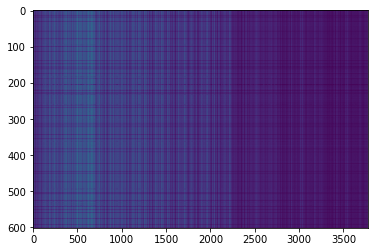

,AUC,pAUC
Source_0,0.784000,0.637368
Source_1,0.902500,0.770526
Source_2,0.836453,0.799231
Target_0,0.480000,0.481053
Target_1,0.650306,0.571106
Target_2,0.619473,0.523969
mean,0.712122,0.630542
h_mean,0.680703,0.608751


2021-05-26 23:13:27,604 - pytorch_modeler.py - INFO - epoch:283/300, train_losses:15040.939860, val_AUC_hmean:0.680703, val_pAUC_hmean:0.608751, best_flag:True
2021-05-26 23:13:27,606 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.58it/s]
2021-05-26 23:13:28,432 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.10it/s]
2021-05-26 23:13:28,639 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 131.78411865234375, KLd: 0.48552054166793823, center_loss: 131.2781524658203


100%|██████████| 2/2 [00:00<00:00,  9.57it/s]
2021-05-26 23:13:28,903 - pytorch_modeler.py - INFO - epoch:284/300, train_losses:14984.677083, val_AUC_hmean:0.688194, val_pAUC_hmean:0.590382, best_flag:False
2021-05-26 23:13:28,905 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.40it/s]
2021-05-26 23:13:29,803 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.30it/s]
2021-05-26 23:13:30,027 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 132.9473876953125, KLd: 0.4841901659965515, center_loss: 132.43862915039062


100%|██████████| 2/2 [00:00<00:00,  9.61it/s]
2021-05-26 23:13:30,257 - pytorch_modeler.py - INFO - epoch:285/300, train_losses:14955.915283, val_AUC_hmean:0.694982, val_pAUC_hmean:0.579512, best_flag:False
2021-05-26 23:13:30,258 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.86it/s]
2021-05-26 23:13:31,127 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.28it/s]
2021-05-26 23:13:31,348 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 132.557861328125, KLd: 0.5442463159561157, center_loss: 131.990234375


100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
2021-05-26 23:13:31,557 - pytorch_modeler.py - INFO - epoch:286/300, train_losses:14908.303304, val_AUC_hmean:0.686128, val_pAUC_hmean:0.591063, best_flag:False
2021-05-26 23:13:31,559 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.31it/s]
2021-05-26 23:13:32,345 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.89it/s]
2021-05-26 23:13:32,568 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 133.31719970703125, KLd: 0.5207068920135498, center_loss: 132.76722717285156


100%|██████████| 2/2 [00:00<00:00, 10.33it/s]
2021-05-26 23:13:32,786 - pytorch_modeler.py - INFO - epoch:287/300, train_losses:14872.307617, val_AUC_hmean:0.674551, val_pAUC_hmean:0.578156, best_flag:False
2021-05-26 23:13:32,787 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.92it/s]
2021-05-26 23:13:33,652 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.08it/s]
2021-05-26 23:13:33,875 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 131.02398681640625, KLd: 0.4562060236930847, center_loss: 130.54562377929688


100%|██████████| 2/2 [00:00<00:00,  9.71it/s]
2021-05-26 23:13:34,108 - pytorch_modeler.py - INFO - epoch:288/300, train_losses:14818.526042, val_AUC_hmean:0.690516, val_pAUC_hmean:0.591781, best_flag:False
2021-05-26 23:13:34,109 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.01it/s]
2021-05-26 23:13:34,968 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.67it/s]
2021-05-26 23:13:35,179 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 129.19097900390625, KLd: 0.42722439765930176, center_loss: 128.73846435546875


100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
2021-05-26 23:13:35,383 - pytorch_modeler.py - INFO - epoch:289/300, train_losses:14788.921305, val_AUC_hmean:0.694087, val_pAUC_hmean:0.595472, best_flag:False
2021-05-26 23:13:35,384 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.36it/s]
2021-05-26 23:13:35,924 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
2021-05-26 23:13:36,123 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 129.2907257080078, KLd: 0.4060679078102112, center_loss: 128.85906982421875


100%|██████████| 2/2 [00:00<00:00, 11.71it/s]
2021-05-26 23:13:36,318 - pytorch_modeler.py - INFO - epoch:290/300, train_losses:14751.942301, val_AUC_hmean:0.697740, val_pAUC_hmean:0.592528, best_flag:False
2021-05-26 23:13:36,319 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.64it/s]
2021-05-26 23:13:36,851 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.91it/s]
2021-05-26 23:13:37,041 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 129.2320556640625, KLd: 0.406015545129776, center_loss: 128.80093383789062


100%|██████████| 2/2 [00:00<00:00, 11.85it/s]
2021-05-26 23:13:37,232 - pytorch_modeler.py - INFO - epoch:291/300, train_losses:14724.673503, val_AUC_hmean:0.696211, val_pAUC_hmean:0.596302, best_flag:False
2021-05-26 23:13:37,233 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.89it/s]
2021-05-26 23:13:37,760 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.54it/s]
2021-05-26 23:13:37,969 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 129.42166137695312, KLd: 0.39972546696662903, center_loss: 128.99559020996094


100%|██████████| 2/2 [00:00<00:00, 11.46it/s]
2021-05-26 23:13:38,168 - pytorch_modeler.py - INFO - epoch:292/300, train_losses:14691.066406, val_AUC_hmean:0.691606, val_pAUC_hmean:0.591967, best_flag:False
2021-05-26 23:13:38,169 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.51it/s]
2021-05-26 23:13:38,704 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.86it/s]
2021-05-26 23:13:38,909 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 128.56260681152344, KLd: 0.41511744260787964, center_loss: 128.12322998046875


100%|██████████| 2/2 [00:00<00:00, 11.86it/s]
2021-05-26 23:13:39,103 - pytorch_modeler.py - INFO - epoch:293/300, train_losses:14663.578695, val_AUC_hmean:0.694316, val_pAUC_hmean:0.594261, best_flag:False
2021-05-26 23:13:39,105 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.99it/s]
2021-05-26 23:13:39,653 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.56it/s]
2021-05-26 23:13:39,846 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 128.73568725585938, KLd: 0.388174831867218, center_loss: 128.32275390625


100%|██████████| 2/2 [00:00<00:00, 12.19it/s]
2021-05-26 23:13:40,033 - pytorch_modeler.py - INFO - epoch:294/300, train_losses:14630.026774, val_AUC_hmean:0.696212, val_pAUC_hmean:0.593491, best_flag:False
2021-05-26 23:13:40,034 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.68it/s]
2021-05-26 23:13:40,590 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.76it/s]
2021-05-26 23:13:40,782 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 128.34896850585938, KLd: 0.3866218626499176, center_loss: 127.93939971923828


100%|██████████| 2/2 [00:00<00:00, 12.14it/s]
2021-05-26 23:13:40,969 - pytorch_modeler.py - INFO - epoch:295/300, train_losses:14608.221273, val_AUC_hmean:0.694003, val_pAUC_hmean:0.592613, best_flag:False
2021-05-26 23:13:40,970 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.97it/s]
2021-05-26 23:13:41,495 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.43it/s]
2021-05-26 23:13:41,675 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 128.13388061523438, KLd: 0.377321720123291, center_loss: 127.73652648925781


100%|██████████| 2/2 [00:00<00:00, 12.37it/s]
2021-05-26 23:13:41,858 - pytorch_modeler.py - INFO - epoch:296/300, train_losses:14568.823161, val_AUC_hmean:0.695222, val_pAUC_hmean:0.593660, best_flag:False
2021-05-26 23:13:41,859 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.94it/s]
2021-05-26 23:13:42,384 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.95it/s]
2021-05-26 23:13:42,573 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 127.92244720458984, KLd: 0.38272321224212646, center_loss: 127.51905822753906


100%|██████████| 2/2 [00:00<00:00, 12.23it/s]
2021-05-26 23:13:42,758 - pytorch_modeler.py - INFO - epoch:297/300, train_losses:14542.422770, val_AUC_hmean:0.693720, val_pAUC_hmean:0.593055, best_flag:False
2021-05-26 23:13:42,759 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.83it/s]
2021-05-26 23:13:43,287 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 11.65it/s]
2021-05-26 23:13:43,478 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 128.33126831054688, KLd: 0.3698187470436096, center_loss: 127.93701171875


100%|██████████| 2/2 [00:00<00:00, 11.58it/s]
2021-05-26 23:13:43,675 - pytorch_modeler.py - INFO - epoch:298/300, train_losses:14523.216390, val_AUC_hmean:0.694776, val_pAUC_hmean:0.590017, best_flag:False
2021-05-26 23:13:43,676 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.30it/s]
2021-05-26 23:13:44,216 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 12.29it/s]
2021-05-26 23:13:44,399 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 127.73040771484375, KLd: 0.36509835720062256, center_loss: 127.33979034423828


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]
2021-05-26 23:13:44,594 - pytorch_modeler.py - INFO - epoch:299/300, train_losses:14478.545085, val_AUC_hmean:0.696461, val_pAUC_hmean:0.593247, best_flag:False
2021-05-26 23:13:44,594 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.64it/s]
2021-05-26 23:13:45,127 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.80it/s]
2021-05-26 23:13:45,333 - pytorch_modeler.py - INFO - valid_target
  0%|          | 0/2 [00:00<?, ?it/s]

reconst: 127.67450714111328, KLd: 0.3863077163696289, center_loss: 127.25752258300781


100%|██████████| 2/2 [00:00<00:00, 11.91it/s]
2021-05-26 23:13:45,525 - pytorch_modeler.py - INFO - epoch:300/300, train_losses:14448.465983, val_AUC_hmean:0.696136, val_pAUC_hmean:0.592115, best_flag:False
2021-05-26 23:13:45,526 - pytorch_modeler.py - INFO - best model, epoch:283/300, train_losses:15040.939860, val_pAUC_hmean:0.608751,


,AUC,pAUC
Source_0,0.784000,0.637368
Source_1,0.902500,0.770526
Source_2,0.836453,0.799231
Target_0,0.480000,0.481053
Target_1,0.650306,0.571106
Target_2,0.619473,0.523969
mean,0.712122,0.630542
h_mean,0.680703,0.608751


elapsed time: 396.409531593 [sec]


In [14]:
run(machine_types[6])